## Import libraries

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.integrate import simpson

## Important functions for calculations

### Trigonometry functions in degree

In [2]:
def sind(t):
    return math.sin(math.radians(t))
def cosd(t):
    return math.cos(math.radians(t))
def tand(t):
    return math.tan(math.radians(t))
def asind(t):
    return math.degrees(math.asin(t))
def acosd(t):
    return math.degrees(math.acos(t))
def atand(t):
    return math.degrees(math.atan(t))

### Interpolation function

In [3]:
def interpolate(x,y):
    X_Y_Spline = make_interp_spline(x, y)
    X_ = np.linspace(min(x), max(x), 500)
    Y_ = X_Y_Spline(X_)
    return X_,Y_

In [4]:
# Declitaion angle
def decl(n):
    de = 23.45*sind((360*(284+n))/365)
    return de
# Hour angle
def ha(st):
    return 15*(12-st)

#Theta
def theta(beta , delta , gamma , omega , phi):
    ca = sind(phi)*(sind(delta)*cosd(beta)+cosd(delta)*cosd(gamma)*cosd(omega)*sind(beta)) + cosd(phi)*(cosd(delta)*cosd(omega)*cosd(beta)-sind(delta)*cosd(gamma)*sind(beta)) + cosd(delta)*sind(gamma)*sind(omega)*sind(beta)
    return acosd(ca)

#Theta Z
def theta_z(delta , gamma , omega , phi):
    return theta(0, delta , gamma ,omega ,phi)

#Tilt factor beam
def rb(n, st , beta ,gamma, phi):
    ca = cosd(theta(beta, decl(n), gamma, ha(st),phi))
    caz = cosd(theta_z(decl(n), gamma, ha(st),phi))
    rb = ca/caz
    return rb

#Tilt factor diffuse
def rd(beta):
    return 0.5*(1+cosd(beta))

#Tilt factor reflected
def rr(beta, rohg):
    return (rohg/2)*(1-cosd(beta))

#Theta dash
def thetadash(ng , na , theta):
    return asind(sind(theta)*(na/ng))

#Total solar radiation flux
def I_total(Ibh,Idh , rb , rd , rr):
    return (Ibh*rb + Idh*rd + (Ibh+Idh)*rr)

def roh1(theta , thetad):
    return pow(sind(thetad-theta),2)/pow(sind(thetad+theta),2)
def roh2(theta , thetad):
    return pow(tand(thetad-theta),2)/pow(tand(thetad+theta),2)
def tau1(roh1 , m):
    return (1-roh1)/(1+roh1*(2*m-1))
def tau2(roh2 , m):
    return (1-roh2)/(1+roh2*(2*m-1))
def tau_a(theta_d,k,delC):
    return math.exp(-(k*delC)/cosd(theta_d))
def alpha(theta):
    if theta-85 > 5:
        return 0
    up = 0.0106944*(theta-90)*(1-0.254*pow((cosd(theta)/cosd(85)),4*(theta-85)))
    down = pow((theta/95.406),0.9775)-1
    if type(up/down) == complex:
        return 0
    else:
        return up/down
def tau_alp_b(tau,alpha,roh_d):
    return (tau*alpha)/(1-(1-alpha)*roh_d)
def tau_alp_d(theta ,ng,na,m,k,delC,roh_d):
    td = thetadash(ng,na,theta)
    roh_1 = roh1(theta,td)
    roh_2 = roh2(theta,td)
    tau_1 =  tau1(roh_1,m)
    tau_2 =  tau2(roh_2,m)
    taua = tau_a(td,k,delC)
    alp = alpha(theta)
    return tau_alp_b((taua*0.5*(tau_1+tau_2)),alp,roh_d)
def S(Ibh, Idh, rb, rd, rr, tau_b , tau_d):
    return (Ibh*rb*tau_b + (Idh*rd+(Ibh+Idh)*rr)*tau_d)
def fin_eff(U,K,cpst,L):
    m = pow((U/(K*cpst)),0.5)
    return ((math.exp(m*L)-math.exp(-m*L))/(math.exp(m*L)+math.exp(-m*L)))/(m*L)
def collector_eff(U,W,L,F,Do,cb,Di,hci):
    up = 1/U
    down1 = 1/(U*(2*L*F+Do))
    down2 = 1/cb
    down3 = 1/(hci*math.pi*Di)
    return up/(W*(down1+down2+down3))
def hear_removal_factor(mw,cw,U,fd):
    return (mw*cw/U)*(1-math.exp((-U*fd)/(mw*cw)))

In [5]:
st = [6,7,8,9,10,11,12,13,14,15,16,17,18]
st_t = [6,7,8,9,10,11,12,13,14,15,16,17,18,'Daily']
I = [
    [[0,0,147,300,426,509,537,509,426,300,147,0,0],[0,0,56,77,91,98,98,98,91,77,56,0,0]],
    [[0,42,216,391,502,593,621,593,502,391,216,42,0],[0,25,70,91,98,105,105,105,98,91,70,28,0]],
    [[0,105,293,453,593,649,712,649,593,453,293,105,0],[0,49,84,98,105,105,105,105,105,98,84,49,0]],
    [[0,160,356,523,663,747,767,747,663,523,356,160,0],[0,70,91,98,105,112,112,112,105,98,91,70,0]],
    [[42,209,398,565,705,788,816,788,705,565,398,209,42],[42,77,98,105,105,112,112,112,105,105,98,77,42]],
    [[63,230,412,586,705,788,816,788,705,586,412,230,63],[49,77,98,105,112,112,112,112,112,105,98,77,49]],
    [[56,223,405,565,684,767,795,767,684,565,405,223,56],[42,77,98,105,105,112,112,112,105,105,98,77,42]],
    [[28,188,363,530,670,753,781,753,670,530,363,188,28],[35,70,91,105,105,112,112,112,105,105,91,70,35]],
    [[0,119,307,474,607,698,726,698,607,474,307,119,0],[0,63,84,98,105,105,112,105,105,98,84,63,0]],
    [[0,49,223,384,516,593,628,593,516,384,223,49,0],[0,35,77,91,98,105,105,105,98,91,77,35,0]],
    [[0,0,147,300,419,495,523,495,419,300,147,0,0],[0,0,63,84,91,98,98,98,91,84,63,0,0]],
    [[0,0,112,265,391,460,495,460,391,265,112,0,0],[0,0,49,77,91,98,98,98,91,77,49,0,0]]
]

Twi = [14.8, 16.1, 19.4, 22.7, 24.3, 27.5, 28.5, 29.3, 27.9, 26, 21.4, 17.6]
Ta_r = [
    [8.8, 19.7],
    [9.8, 21.2],
    [11.9, 24.4],
    [14.8, 28.5],
    [17.5, 32.2],
    [20.7, 34.9],
    [22, 34.7],
    [22.3, 34.5],
    [20.6, 33.1],
    [18.1, 30.6],
    [14, 25.5],
    [10.3, 21.1]   
]
DR = [98,93,84,71,56,39,23,11,3,0,3,10,21]
avg_d = [17,47,75,105,135,162,198,228,258,288,318,334]
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [6]:
srs = []
sss = []
for i in range(12):
        ws = -acosd(-tand(30)*tand(decl(30*i+15)))
        sr = round(12+ws/15,2)
        ss = round(12-(ws/15),2)
        srs.append(sr)
        sss.append(ss)        

In [7]:
gamma = 20
beta = 40
phi = 30
n_o_c = 1
k = 0.0068
ng = 1.526
na = 1
delC = 4
roh_g = 0.2
U = 5
K = 385
cpst = 0.5/1000
Do= 11/1000
Di= 10/1000
cb = 35
W = 150/1000
mw = 0.015
cw = 4180
hci = 300
twh=55
vw = 220
Twh=55
thta_diff = 20
if n_o_c == 1 :
    roh_d = 0.15
elif n_o_c == 2:
    roh_d = 0.22
elif n_o_c == 3: 
    roh_d = 0.24

# Working on average days

In [8]:
def iqs_4m(m,gamma):
    gamma = gamma
    n = avg_d[m-1]
    I_total_m = []
    S_m = []
    Q_m = []
    Ac_m =[]
    NOT_m =[]
    Eff_m =[]
    for i in range(10):
        beta = 10*i
        theta_in = []
        theta_z_in = []
        rb_in = []
        I_total_in = []
        thetadash_in = []
        roh1_in = []
        roh2_in = []
        tau1_in = []
        tau2_in = []
        tau_r = []
        tau_a_in = []
        tau = []
        alpha_in = []
        tau_a_b_in = []
        S_in = []
        qu = []

        # DIFFUSE
        rd_in = rd(beta)
        rr_in = rr(beta, roh_g)
        tau_a_d_in = tau_alp_d(thta_diff, ng, na, n_o_c, k, delC, roh_d)

        # TANK
        L = (W-Do)/2
        F = fin_eff(U,K,cpst,L)
        F_d = collector_eff(U,W,L,F,Do,cb,Di,hci)
        FR = hear_removal_factor(mw,cw,U,F_d)
        for i in range(len(st)):
            theta_in.append(theta(beta,decl(n),gamma,ha(st[i]),phi))
            theta_z_in.append(theta_z(decl(n),gamma,ha(st[i]),phi))
            if rb(n,st[i],beta ,gamma, phi) < 0:
                rb_in.append(0)
            else:
                rb_in.append(rb(n,st[i],beta ,gamma, phi))
            I_total_in.append(I_total(I[m-1][0][i],I[m-1][1][i],rb_in[i],rd(beta),rr(beta,0.2)))
            thetadash_in.append(thetadash(ng,na,theta_in[i]))
            roh1_in.append(roh1(theta_in[i],thetadash_in[i]))
            roh2_in.append(roh2(theta_in[i],thetadash_in[i]))
            tau1_in.append(tau1(roh1_in[i],n_o_c))
            tau2_in.append(tau1(roh2_in[i],n_o_c))
            tau_r.append((tau1_in[i]+tau2_in[i])*0.5)
            tau_a_in.append(tau_a(thetadash_in[i],k,delC))
            tau.append(tau_a_in[i]*tau_r[i])  
            alpha_in.append(alpha(theta_in[i]))
            tau_a_b_in.append(tau_alp_b(tau[i],alpha_in[i],roh_d))
            S_in.append(S(I[m-1][0][i],I[m-1][1][i],rb_in[i], rd_in, rr_in, tau_a_b_in[i], tau_a_d_in))
        ta = Ta_r[m-1][1] - DR[0]*(Ta_r[m-1][1]-Ta_r[m-1][0])/100
        tw_n = [Twi[m-1]]
        if FR*(S_in[0]-U*(Twi[m-1]-ta)) < 0 :
            qu.append(0)
        else:
            qu.append(FR*(S_in[0]-U*(Twi[m-1]-ta)))

        for i in range(1,len(st)): 
            two = tw_n[i-1]+(qu[i-1]/(mw*cw))
            tw_n.append((two+tw_n[i-1])/2)
            ta = Ta_r[m-1][1] - DR[i]*(Ta_r[m-1][1]-Ta_r[m-1][0])/100
            if FR*(S_in[i]-U*(tw_n[i]-ta)) > 0: 
                qu.append(FR*(S_in[i]-U*(tw_n[i]-ta)))
            else:
                qu.append(0)
        I_total_daily = sum(I_total_in[1:len(I_total_in)])*(3600/pow(10,6))
        S_daily = sum(S_in[1:len(S_in)])*(3600/pow(10,6))
        Q_daily = sum(qu[1:len(qu)])*(3600/pow(10,6))
        I_total_in.append(I_total_daily)
        S_in.append(S_daily)
        qu.append(Q_daily)
        Ac = (vw*cw*(Twh-Twi[m-1]))/(Q_daily*pow(10,6))
        Ac_m.append(Ac)
        NOT_m.append(int((Ac/2)/W))
        Eff_m.append(Q_daily/I_total_daily)
        I_total_m.append(I_total_in)
        S_m.append(S_in)
        Q_m.append(qu)
    return I_total_m,S_m,Q_m,Ac_m,NOT_m,Eff_m

In [9]:
full_data = []
for x in range(12):
    gamma_l = 0
    I_total_m = iqs_4m(x+1,gamma_l)[0]
    S_m = iqs_4m(x+1,gamma_l)[1]
    Q_m = iqs_4m(x+1,gamma_l)[2]
    Ac_m = iqs_4m(x+1,gamma_l)[3]
    NOT_m = iqs_4m(x+1,gamma_l)[4]
    Eff_m = iqs_4m(x+1,gamma_l)[5]
    I_avg = pd.DataFrame(data= {
    "ST":st_t,
    "Beta = 0" : I_total_m[0],
    "Beta = 10" : I_total_m[1],
    "Beta = 20" : I_total_m[2],
    "Beta = 30" : I_total_m[3],
    "Beta = 40" : I_total_m[4],
    "Beta = 50" : I_total_m[5],
    "Beta = 60" : I_total_m[6],
    "Beta = 70" : I_total_m[7],
    "Beta = 80" : I_total_m[8],
    "Beta = 90" : I_total_m[9]
    })
    S_avg = pd.DataFrame(data= {
        "ST":st_t,
        "Beta = 0" : S_m[0],
        "Beta = 10" : S_m[1],
        "Beta = 20" : S_m[2],
        "Beta = 30" : S_m[3],
        "Beta = 40" : S_m[4],
        "Beta = 50" : S_m[5],
        "Beta = 60" : S_m[6],
        "Beta = 70" : S_m[7],
        "Beta = 80" : S_m[8],
        "Beta = 90" : S_m[9],
    })
    Q_avg = pd.DataFrame(data= {
        "ST":st_t,
        "Beta = 0" : Q_m[0],
        "Beta = 10" : Q_m[1],
        "Beta = 20" : Q_m[2],
        "Beta = 30" : Q_m[3],
        "Beta = 40" : Q_m[4],
        "Beta = 50" : Q_m[5],
        "Beta = 60" : Q_m[6],
        "Beta = 70" : Q_m[7],
        "Beta = 80" : Q_m[8],
        "Beta = 90" : Q_m[9],
    })
    Dim = pd.DataFrame(data={
        "Tilt Angle" : list(range(0,100,10)),
        "Area of collector" : Ac_m,
        "Number of tubes" : NOT_m,
        "Collector efficiency" : Eff_m
    })
    full_data.append([I_avg,S_avg,Q_avg,Dim])

# All months

# Januaury

## Total solar radiation

In [10]:
full_data[0][0]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,8,203.0000,261.955975,314.420121,358.798343,393.742229,418.190028,431.398905,432.967516,422.848199,401.348425
3,9,377.0000,457.081701,525.590503,580.444803,619.977880,642.988541,648.777619,637.169215,608.516046,563.688723
4,10,517.0000,611.744208,690.854251,751.926410,793.105039,813.138944,811.419408,787.998676,743.588375,679.537891
5,11,607.0000,710.913274,796.558986,861.334836,903.272641,921.098144,914.269724,882.994861,828.223824,751.620805
6,12,635.0000,741.874440,829.625655,895.587371,937.755373,954.848408,946.347113,912.509795,854.364585,773.678195
7,13,607.0000,710.913274,796.558986,861.334836,903.272641,921.098144,914.269724,882.994861,828.223824,751.620805
8,14,517.0000,611.744208,690.854251,751.926410,793.105039,813.138944,811.419408,787.998676,743.588375,679.537891
9,15,377.0000,457.081701,525.590503,580.444803,619.977880,642.988541,648.777619,637.169215,608.516046,563.688723


## Total absorbed solar radiation


In [11]:
full_data[0][1]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,8,108.821752,162.567099,215.771679,262.213529,298.946440,324.586762,338.468168,340.302563,330.064578,307.973649
3,9,259.577858,343.254645,414.571288,470.768255,510.680481,533.691000,539.466582,527.924318,499.234250,453.817970
4,10,394.826661,492.767660,572.574506,632.943753,673.106661,692.475833,690.709400,667.830494,624.207466,560.426712
5,11,482.614015,588.025165,672.629086,735.508792,775.868163,792.915305,786.144403,755.773510,702.474889,626.972755
6,12,510.248365,617.919461,704.044451,767.787987,808.335564,824.382595,816.227441,783.300423,726.820168,647.529726
7,13,482.614015,588.025165,672.629086,735.508792,775.868163,792.915305,786.144403,755.773510,702.474889,626.972755
8,14,394.826661,492.767660,572.574506,632.943753,673.106661,692.475833,690.709400,667.830494,624.207466,560.426712
9,15,259.577858,343.254645,414.571288,470.768255,510.680481,533.691000,539.466582,527.924318,499.234250,453.817970


## Usefull energy rate


In [12]:
full_data[0][2]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,8,74.209294,119.769318,164.870932,204.239769,235.378320,257.113666,268.880957,270.435977,261.757220,243.030701
3,9,205.503205,274.896237,333.827048,380.134650,412.915833,431.687237,436.185474,426.348518,402.321239,364.454735
4,10,320.137820,399.277171,463.413286,511.692545,543.578229,558.628386,556.581204,537.466645,501.592790,449.438573
5,11,391.588639,474.385547,540.420355,589.195900,620.170394,632.743467,626.523183,601.703724,558.840385,498.512743
6,12,409.170623,491.084764,556.177015,604.036221,634.123322,645.423631,638.240158,612.092763,567.981125,506.481196
7,13,377.458977,454.688666,516.291392,561.800691,590.711308,602.477464,596.710226,573.613441,533.689848,477.479967
8,14,293.979386,362.266259,417.720329,459.563297,487.330196,500.667046,499.337037,483.371892,452.999730,408.625971
9,15,170.778258,224.665244,271.047812,307.939642,334.555520,350.528361,355.636684,349.821252,333.134362,305.828029


## Size & efficiency


In [13]:
full_data[0][3]

,Tilt Angle,Area of collector,Number of tubes,Collector efficiency
0,0,4.506557,15,0.563604
1,10,3.586062,11,0.593449
2,20,3.060085,10,0.611863
3,30,2.747188,9,0.622931
4,40,2.566487,8,0.629312
5,50,2.480819,8,0.632372
6,60,2.474462,8,0.632798
7,70,2.546578,8,0.630581
8,80,2.709893,9,0.625239
9,90,2.998801,9,0.615214


# February






## Total solar radiation

In [14]:
full_data[1][0]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,67.000,88.236615,107.375588,123.835390,137.115898,146.813592,152.633811,154.399712,152.057637,145.678751
2,8,286.000,335.606749,376.948710,408.769730,430.102942,440.300147,439.051509,426.394967,402.715084,368.731360
3,9,482.000,551.561999,607.212093,647.259381,670.487048,676.189332,664.192973,634.862474,589.089026,528.263434
4,10,600.000,679.333757,741.338212,784.129390,806.407104,807.494455,787.358406,746.610780,686.489673,608.821834
5,11,698.000,786.615208,855.045534,901.211759,923.711143,921.860056,895.714741,846.069610,774.433106,682.981867
6,12,726.000,817.269623,887.508022,934.581040,957.058385,954.257096,926.262289,873.924570,798.834196,703.272749
7,13,698.000,786.615208,855.045534,901.211759,923.711143,921.860056,895.714741,846.069610,774.433106,682.981867
8,14,600.000,679.333757,741.338212,784.129390,806.407104,807.494455,787.358406,746.610780,686.489673,608.821834
9,15,482.000,551.561999,607.212093,647.259381,670.487048,676.189332,664.192973,634.862474,589.089026,528.263434


## Total absorbed solar radiation


In [15]:
full_data[1][1]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,27.858037,39.405425,52.826739,66.522269,78.682046,88.066050,93.907787,95.796141,93.594765,87.409686
2,8,178.187673,228.050134,271.078957,304.507040,326.955186,337.747562,336.614455,323.588069,299.004562,263.614818
3,9,359.668645,432.232382,489.461774,530.065864,553.374078,559.034245,546.958306,517.319717,470.565704,407.533916
4,10,480.295777,560.705661,622.229222,664.065872,685.619139,686.521519,666.742268,626.586623,566.589328,487.497459
5,11,574.212291,662.185528,728.803108,773.270139,794.791129,792.775741,767.289878,718.931913,648.401066,556.415596
6,12,601.594928,691.612095,759.650388,804.916504,826.363000,823.461629,796.094658,745.208370,671.558335,575.822593
7,13,574.212291,662.185528,728.803108,773.270139,794.791129,792.775741,767.289878,718.931913,648.401066,556.415596
8,14,480.295777,560.705661,622.229222,664.065872,685.619139,686.521519,666.742268,626.586623,566.589328,487.497459
9,15,359.668645,432.232382,489.461774,530.065864,553.374078,559.034245,546.958306,517.319717,470.565704,407.533916


## Usefull energy rate


In [16]:
full_data[1][2]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,0.295032,10.083772,21.461043,33.070768,43.378632,51.333468,56.285518,57.886280,56.020169,50.777067
2,8,132.068461,174.006097,210.097153,238.041790,256.722717,265.602560,264.474644,253.378049,232.601642,202.778911
3,9,287.727762,347.491821,394.400850,427.484073,446.262667,450.491790,440.125741,415.322016,376.453873,324.206940
4,10,387.506268,451.901498,500.865181,533.875037,550.531246,550.584241,534.038452,501.157764,452.377008,388.281858
5,11,462.236012,530.866156,582.493080,616.616985,632.682853,630.260660,609.436612,570.714168,514.652887,441.794220
6,12,477.555825,545.598920,596.685199,630.333105,645.792800,642.701427,620.986611,581.429719,524.619163,451.044000
7,13,444.000452,508.011054,556.166280,587.999505,602.999812,600.763977,581.377738,545.301128,493.054905,425.145689
8,14,353.245606,408.681188,450.890564,479.418049,493.938708,494.251841,480.358361,452.454258,410.903263,356.219299
9,15,240.499678,287.410351,324.552879,351.071295,366.588828,370.924561,364.030791,345.985171,317.064948,277.843455


## Size & efficiency


In [17]:
full_data[1][3]

,Tilt Angle,Area of collector,Number of tubes,Collector efficiency
0,0,3.471713,11,0.573016
1,10,2.951044,9,0.590432
2,20,2.639518,8,0.600775
3,30,2.456889,8,0.606563
4,40,2.366065,7,0.609058
5,50,2.351198,7,0.608784
6,60,2.410039,8,0.605751
7,70,2.552972,8,0.599470
8,80,2.809214,9,0.588514
9,90,3.244037,10,0.569981


# March

## Total solar radiation

In [18]:
full_data[2][0]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,154.000,167.171741,176.476394,181.631243,182.479659,178.995865,171.285714,159.583474,144.244712,125.735489
2,8,377.000,407.880537,428.789475,439.091506,438.473607,426.954555,404.884348,372.933579,332.073057,283.544306
3,9,551.000,596.112851,626.276141,640.573374,638.570134,620.327289,586.399140,537.816575,476.055752,402.993241
4,10,698.000,755.593269,793.944243,811.887646,808.878278,785.007576,741.000839,678.195191,598.498949,504.333642
5,11,754.000,816.292532,857.668605,876.871029,873.316346,847.112566,799.055875,730.606453,643.844100,541.405047
6,12,817.000,885.143172,930.469315,951.601218,947.896799,919.468614,867.180440,792.621026,698.055823,586.358145
7,13,754.000,816.292532,857.668605,876.871029,873.316346,847.112566,799.055875,730.606453,643.844100,541.405047
8,14,698.000,755.593269,793.944243,811.887646,808.878278,785.007576,741.000839,678.195191,598.498949,504.333642
9,15,551.000,596.112851,626.276141,640.573374,638.570134,620.327289,586.399140,537.816575,476.055752,402.993241


## Total absorbed solar radiation


In [19]:
full_data[2][1]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,80.920856,91.389013,99.297511,103.862861,104.659101,101.581176,94.831869,84.937368,72.784512,59.654407
2,8,266.106638,298.383957,320.333330,331.184698,330.619068,318.653126,295.640714,262.392498,220.493482,172.972637
3,9,436.458373,482.699903,513.229837,527.554633,525.452098,506.945678,472.307865,422.110738,357.480600,280.998064
4,10,578.010307,635.066739,672.529611,689.849866,686.725815,663.191561,619.588768,556.469085,474.645623,375.914556
5,11,635.572142,696.200467,736.055283,754.399998,750.724418,725.142289,678.219614,610.596718,522.941294,416.471100
6,12,691.940093,757.959519,801.558999,821.656083,817.866678,790.006606,739.047656,665.703677,570.618909,454.885623
7,13,635.572142,696.200467,736.055283,754.399998,750.724418,725.142289,678.219614,610.596718,522.941294,416.471100
8,14,578.010307,635.066739,672.529611,689.849866,686.725815,663.191561,619.588768,556.469085,474.645623,375.914556
9,15,436.458373,482.699903,513.229837,527.554633,525.452098,506.945678,472.307865,422.110738,357.480600,280.998064


## Usefull energy rate


In [20]:
full_data[2][2]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,40.516629,49.390504,56.094552,59.964607,60.639581,58.030418,52.309020,43.921434,33.619437,22.489024
2,8,200.897800,227.959403,246.339328,255.407244,254.904945,244.849584,225.535306,197.634236,162.464574,122.557279
3,9,345.402509,383.386918,408.419360,420.125212,418.337053,403.077188,374.560858,333.235220,279.985079,216.875771
4,10,461.668958,507.537308,537.600719,551.450170,548.856511,529.850324,494.698214,443.814906,377.789804,297.953467
5,11,503.866686,551.212591,582.287516,596.537294,593.563767,573.464001,536.685760,483.704922,414.967698,331.269350
6,12,543.096265,593.411928,626.610881,641.864503,638.894992,617.543581,578.586883,522.547020,449.835241,361.113551
7,13,483.314214,527.359166,556.261640,569.514205,566.741553,548.042833,513.824426,464.528477,400.572217,322.701651
8,14,422.421480,461.949816,487.847734,499.783927,497.572523,481.241805,450.994246,407.181878,350.331097,281.653021
9,15,289.739294,318.763765,337.909273,346.902767,345.632049,334.115412,312.489847,281.112805,240.758386,193.261741


## Size & efficiency


In [21]:
full_data[2][3]

,Tilt Angle,Area of collector,Number of tubes,Collector efficiency
0,0,2.655229,8,0.581967
1,10,2.411434,8,0.591898
2,20,2.273029,7,0.597414
3,30,2.213322,7,0.599657
4,40,2.222155,7,0.599055
5,50,2.301166,7,0.595490
6,60,2.464276,8,0.588330
7,70,2.745463,9,0.575964
8,80,3.218789,10,0.555329
9,90,4.053514,13,0.521442


# April

## Total solar radiation

In [22]:
full_data[3][0]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,230.0000,226.102824,217.097929,203.258924,185.006299,162.894653,137.595836,109.878539,80.584940,58.000000
2,8,447.0000,454.328384,450.592911,435.907082,410.717118,375.788404,332.182230,281.223549,224.460715,163.618436
3,9,621.0000,640.677613,644.264277,631.651015,603.221074,559.838283,502.820807,433.901091,355.173228,269.029324
4,10,768.0000,798.300674,808.274101,797.617244,766.653906,716.324891,648.159422,564.228673,467.082835,359.673638
5,11,859.0000,895.983873,910.055290,900.786697,868.459715,814.056584,739.230316,646.254468,537.954065,417.619759
6,12,879.0000,917.854806,933.193388,924.549689,892.186344,837.086697,760.924924,666.015160,555.241191,431.968829
7,13,859.0000,895.983873,910.055290,900.786697,868.459715,814.056584,739.230316,646.254468,537.954065,417.619759
8,14,768.0000,798.300674,808.274101,797.617244,766.653906,716.324891,648.159422,564.228673,467.082835,359.673638
9,15,621.0000,640.677613,644.264277,631.651015,603.221074,559.838283,502.820807,433.901091,355.173228,269.029324


## Total absorbed solar radiation


In [23]:
full_data[3][1]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,146.006087,142.287083,133.842978,121.298649,105.730516,88.761339,72.569352,58.237312,52.292518,49.756413
2,8,340.012056,347.676592,343.778807,328.419774,302.037335,265.569772,220.864922,171.530709,124.270188,88.240499
3,9,508.551342,528.323467,531.834357,519.023971,490.070788,445.412847,385.893157,313.347528,232.441938,155.086237
4,10,648.127765,677.656721,687.226067,676.658640,646.113719,596.014202,526.965739,439.950214,337.578582,228.861530
5,11,734.017516,769.664933,783.098088,773.918642,742.400441,689.173351,614.893335,520.278975,406.937617,281.522805
6,12,753.757234,791.213410,805.541304,797.276782,765.680176,711.969091,636.812877,540.852943,425.398386,296.253448
7,13,734.017516,769.664933,783.098088,773.918642,742.400441,689.173351,614.893335,520.278975,406.937617,281.522805
8,14,648.127765,677.656721,687.226067,676.658640,646.113719,596.014202,526.965739,439.950214,337.578582,228.861530
9,15,508.551342,528.323467,531.834357,519.023971,490.070788,445.412847,385.893157,313.347528,232.441938,155.086237


## Usefull energy rate


In [24]:
full_data[3][2]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,94.350123,91.197517,84.039435,73.405586,60.208453,45.823652,32.097677,19.948382,14.908970,12.759109
2,8,260.846374,267.450172,264.387955,251.727500,229.809123,199.381711,161.949270,120.539217,80.646724,50.176959
3,9,402.449618,419.093832,422.415464,412.343424,388.986662,352.644696,303.918902,244.232149,177.167034,112.695014
4,10,515.876167,540.228691,548.573816,540.743570,516.826944,477.100501,421.944077,352.008575,269.013455,180.135511
5,11,581.119975,609.836016,621.174435,614.785444,590.852147,549.817206,492.090267,418.077033,328.588085,228.559487
6,12,587.502377,616.781106,628.494759,623.097298,599.906482,559.848233,503.329705,430.677466,342.421873,242.612200
7,13,557.879565,584.635388,595.194649,589.204039,566.863533,528.569533,474.704082,405.648127,322.166928,228.892846
8,14,470.859802,491.524651,498.451651,491.486930,470.726582,436.378165,388.768157,328.487833,257.127347,181.160641
9,15,338.367636,350.063131,351.620237,342.989562,324.280232,295.705621,257.782385,211.805686,161.053978,114.240011


## Size & efficiency


In [25]:
full_data[3][3]

,Tilt Angle,Area of collector,Number of tubes,Collector efficiency
0,0,2.063126,6,0.594323
1,10,1.986165,6,0.597838
2,20,1.967801,6,0.599524
3,30,2.008552,6,0.598553
4,40,2.115256,7,0.594583
5,50,2.306780,7,0.586850
6,60,2.624304,8,0.573631
7,70,3.156276,10,0.551851
8,80,4.094178,13,0.518629
9,90,5.823872,19,0.477359


# May

## Total solar radiation

In [26]:
full_data[4][0]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,84.0000,70.538270,55.826574,40.311920,39.052160,37.499124,35.700000,33.709454,31.587967,29.400000
1,7,286.0000,267.461399,242.834917,212.868820,178.473610,140.694370,100.679002,70.485999,68.819117,67.100000
2,8,496.0000,484.842605,461.949423,428.016053,384.073543,331.457064,271.765341,206.812077,138.570843,98.600000
3,9,670.0000,669.017897,651.338970,617.500386,568.530312,505.916679,431.561970,347.725417,256.954350,162.006802
4,10,810.0000,818.126938,805.451832,772.359810,719.856356,649.536761,563.537650,464.472063,355.350057,239.487249
5,11,900.0000,914.138082,904.936677,872.675365,818.334390,743.564875,650.638653,542.379241,422.076047,293.384422
6,12,928.0000,944.239718,936.310403,904.452983,849.635430,773.523346,678.429360,567.242853,443.342173,310.491977
7,13,900.0000,914.138082,904.936677,872.675365,818.334390,743.564875,650.638653,542.379241,422.076047,293.384422
8,14,810.0000,818.126938,805.451832,772.359810,719.856356,649.536761,563.537650,464.472063,355.350057,239.487249
9,15,670.0000,669.017897,651.338970,617.500386,568.530312,505.916679,431.561970,347.725417,256.954350,162.006802


## Total absorbed solar radiation


In [27]:
full_data[4][1]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,48.054928,40.617752,36.330342,34.582354,33.501645,32.169343,30.625930,28.918302,27.098344,25.221354
1,7,196.510725,177.721261,153.610530,126.245357,98.945371,76.108469,63.441718,60.467768,59.037800,57.563023
2,8,390.147219,378.565628,354.702630,319.170054,273.210175,219.380774,163.002058,114.192170,87.214628,84.585903
3,9,556.646548,555.637358,537.874943,503.609957,453.350591,388.042695,309.828884,224.454231,146.874422,105.274116
4,10,688.807137,696.644480,684.192703,651.655543,599.493567,528.332088,439.167853,334.715713,224.577981,137.988468
5,11,773.255237,786.843730,777.798465,746.400845,693.303603,619.175998,524.729530,411.491396,285.772605,172.660974
6,12,799.787472,815.199825,807.587213,776.523641,723.136319,648.121092,552.123816,436.371348,306.199849,184.869442
7,13,773.255237,786.843730,777.798465,746.400845,693.303603,619.175998,524.729530,411.491396,285.772605,172.660974
8,14,688.807137,696.644480,684.192703,651.655543,599.493567,528.332088,439.167853,334.715713,224.577981,137.988468
9,15,556.646548,555.637358,537.874943,503.609957,453.350591,388.042695,309.828884,224.454231,146.874422,105.274116


## Usefull energy rate


In [28]:
full_data[4][2]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,13.160508,6.856001,3.221556,1.739784,0.823665,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,141.677223,125.962454,105.646589,82.499169,59.387889,40.056847,29.319221,26.798198,25.586012,24.335841
2,8,306.642083,297.568598,278.149412,248.860850,210.712705,165.762656,118.333253,77.042236,54.214300,52.028180
3,9,445.519167,445.714607,432.123263,404.899190,364.395766,311.234685,246.898743,176.007345,111.055361,75.906856
4,10,551.839330,559.527386,550.897265,526.058044,485.310787,428.984453,357.540367,272.873073,182.517053,110.419136
5,11,615.366044,627.669504,622.218786,599.185119,559.022289,502.085390,428.578349,339.324900,238.814815,146.670955
6,12,627.027121,640.460815,636.408793,614.436835,575.385603,519.620727,447.283595,358.915500,258.028078,162.031602
7,13,590.818970,602.252516,597.122989,575.610509,538.125106,484.997517,416.419996,333.170139,239.467271,153.682538
8,14,504.247028,510.418862,502.575007,480.823656,445.398084,396.580592,334.798743,261.810626,184.482997,124.080626
9,15,377.039947,375.503952,363.423382,340.942544,308.327198,266.121826,215.710891,161.361784,114.247229,94.023881


## Size & efficiency


In [29]:
full_data[4][3]

,Tilt Angle,Area of collector,Number of tubes,Collector efficiency
0,0,1.771531,5,0.603430
1,10,1.772231,5,0.604349
2,20,1.825805,6,0.602817
3,30,1.938958,6,0.599045
4,40,2.125590,7,0.592462
5,50,2.429618,8,0.581220
6,60,2.929487,9,0.563514
7,70,3.776632,12,0.537297
8,80,5.248765,17,0.505022
9,90,7.381193,24,0.515490


# June

## Total solar radiation

In [30]:
full_data[5][0]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,112.000,91.892481,70.077582,47.218138,45.888391,44.249075,42.350000,40.248868,38.009521,35.700000
1,7,307.000,281.490819,249.531288,212.092483,170.311962,125.459205,78.897041,71.867757,70.554456,69.200000
2,8,510.000,490.579517,459.291473,417.086539,365.247091,305.348245,239.209996,168.841922,99.652704,100.000000
3,9,691.000,680.428257,652.876801,609.182767,550.673778,479.127600,396.718126,305.949327,209.579167,121.600000
4,10,817.000,814.798796,792.024287,749.368467,688.127409,610.161893,517.840862,413.969442,301.703716,184.454820
5,11,900.000,903.383484,883.754254,841.708734,778.524457,696.121244,597.002875,484.181013,361.083691,231.451160
6,12,928.000,933.344766,914.851537,873.082219,809.305952,725.460547,624.093602,508.285102,381.553829,247.750449
7,13,900.000,903.383484,883.754254,841.708734,778.524457,696.121244,597.002875,484.181013,361.083691,231.451160
8,14,817.000,814.798796,792.024287,749.368467,688.127409,610.161893,517.840862,413.969442,301.703716,184.454820
9,15,691.000,680.428257,652.876801,609.182767,550.673778,479.127600,396.718126,305.949327,209.579167,121.600000


## Total absorbed solar radiation


In [31]:
full_data[5][1]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,64.537084,51.709883,43.141376,40.506986,39.366237,37.959919,36.330760,34.528264,32.607197,30.625930
1,7,216.377372,190.172659,158.506801,124.383147,92.781145,68.897250,62.729383,61.653135,60.526494,59.364548
2,8,405.207997,385.115276,352.520220,308.296363,254.246053,194.282066,136.699808,94.380312,85.488985,85.786919
3,9,576.404098,565.865064,538.220348,493.859687,433.471721,358.432320,272.257720,184.788784,118.951973,104.316894
4,10,696.244294,694.067378,671.808794,629.828370,568.679177,489.094636,392.534927,283.777441,179.528255,121.394949
5,11,774.339594,777.550763,758.447638,717.556029,655.560573,573.123216,471.114948,352.252105,228.320126,137.814154
6,12,800.810331,805.849107,787.846152,747.249223,684.955536,601.614183,497.964970,376.191054,246.521991,146.993422
7,13,774.339594,777.550763,758.447638,717.556029,655.560573,573.123216,471.114948,352.252105,228.320126,137.814154
8,14,696.244294,694.067378,671.808794,629.828370,568.679177,489.094636,392.534927,283.777441,179.528255,121.394949
9,15,576.404098,565.865064,538.220348,493.859687,433.471721,358.432320,272.257720,184.788784,118.951973,104.316894


## Usefull energy rate


In [32]:
full_data[5][2]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,27.090075,16.216435,8.952897,6.719720,5.752705,4.560566,3.179526,1.651547,0.023055,0.000000
1,7,157.899049,136.052796,109.455101,80.603901,53.847515,33.641389,28.459557,27.598866,26.698853,25.714649
2,8,318.050936,302.124230,275.637852,239.199862,194.318369,144.210053,95.619298,59.825725,52.373995,52.660600
3,9,460.248360,452.958653,431.563923,396.241565,347.504620,286.310506,215.124337,142.267325,86.794678,74.412855
4,10,555.308771,555.354038,539.248281,507.137546,459.402612,396.423932,318.840374,230.399581,144.239668,95.402827
5,11,612.972666,617.583891,604.697396,574.594991,527.756115,464.487771,384.907776,290.889947,190.957094,116.328569
6,12,624.323426,630.328059,618.809741,589.974596,544.466059,482.569860,404.288631,310.980873,209.562405,129.807846
7,13,588.004480,592.256890,580.195276,552.084955,508.367413,449.329619,375.085320,287.399079,194.271881,124.861490
8,14,506.743407,506.284597,491.955776,463.872591,422.350077,367.726092,300.609997,224.453870,151.159502,111.537540
9,15,389.832390,382.300507,363.890164,334.738457,295.264694,246.339917,190.295815,134.760099,96.505310,95.096090


## Size & efficiency


In [33]:
full_data[5][3]

,Tilt Angle,Area of collector,Number of tubes,Collector efficiency
0,0,1.560776,5,0.600906
1,10,1.586706,5,0.600988
2,20,1.662654,5,0.598453
3,30,1.799935,5,0.593199
4,40,2.015802,6,0.584608
5,50,2.366743,7,0.570552
6,60,2.951097,9,0.550277
7,70,3.950045,13,0.517252
8,80,5.596158,18,0.501166
9,90,7.331425,24,0.564669


# July

## Total solar radiation

In [34]:
full_data[6][0]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,98.0000,80.136103,60.773153,40.499485,39.379698,37.999221,36.400000,34.630626,32.744860,30.800000
1,7,300.0000,277.375350,248.404129,213.966611,175.109164,133.012452,88.955561,71.407171,69.976010,68.500000
2,8,503.0000,487.259412,459.730873,421.250824,372.988463,316.410216,253.235185,185.382912,114.915053,99.300000
3,9,670.0000,663.818553,641.098263,602.529473,549.284077,482.979909,405.631588,319.589304,227.467407,132.064976
4,10,789.0000,791.265896,773.482100,736.188965,680.519623,608.165560,521.325216,422.637191,315.100072,201.981320
5,11,879.0000,886.878844,872.182652,835.357960,777.523668,700.437041,606.440318,498.389541,379.567780,253.585371
6,12,907.0000,916.860883,903.320817,866.791211,808.381997,729.867911,633.634563,522.605955,400.155635,270.004193
7,13,879.0000,886.878844,872.182652,835.357960,777.523668,700.437041,606.440318,498.389541,379.567780,253.585371
8,14,789.0000,791.265896,773.482100,736.188965,680.519623,608.165560,521.325216,422.637191,315.100072,201.981320
9,15,670.0000,663.818553,641.098263,602.529473,549.284077,482.979909,405.631588,319.589304,227.467407,132.064976


## Total absorbed solar radiation


In [35]:
full_data[6][1]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,54.321196,43.690358,36.924983,34.743260,33.782630,32.598361,31.226439,29.708547,28.090806,26.422371
1,7,209.054817,185.933797,157.364914,125.935924,95.872088,71.825290,62.756385,61.258012,60.030263,58.764040
2,8,398.005921,381.697337,353.013147,312.704558,262.299864,205.035497,147.733018,102.710641,85.225359,85.186411
3,9,558.030374,551.850970,529.051910,489.955586,435.155271,365.789040,284.614137,199.243137,128.700099,102.620413
4,10,671.811766,673.964020,656.557769,619.878149,564.424351,490.855266,400.349378,296.499867,192.054938,120.107715
5,11,755.854781,763.408342,749.072641,713.267992,656.655491,579.883721,483.714608,370.177657,248.003629,149.307196
6,12,782.293688,791.539621,778.502051,742.969056,686.022828,608.313787,510.509518,394.237101,266.992387,159.128684
7,13,755.854781,763.408342,749.072641,713.267992,656.655491,579.883721,483.714608,370.177657,248.003629,149.307196
8,14,671.811766,673.964020,656.557769,619.878149,564.424351,490.855266,400.349378,296.499867,192.054938,120.107715
9,15,558.030374,551.850970,529.051910,489.955586,435.155271,365.789040,284.614137,199.243137,128.700099,102.620413


## Usefull energy rate


In [36]:
full_data[6][2]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,19.574447,10.562667,4.827647,2.978197,2.163869,1.159962,0.000000,0.000000,0.000000,0.000000
1,7,152.772242,133.477112,109.453064,82.873165,57.415524,37.064944,29.416424,28.146251,27.105486,26.032106
2,8,312.627347,299.759303,276.449520,243.240769,201.400612,153.579289,105.301605,67.178990,52.391864,52.395128
3,9,444.711353,440.864772,423.331692,392.273033,348.120895,291.657157,224.774559,153.736888,94.472414,72.400789
4,10,534.207191,537.553385,525.184415,497.224179,454.010421,395.892386,323.360521,239.059652,153.059620,92.852023
5,11,596.545386,604.357175,595.009186,568.735719,526.000346,467.131775,392.250755,302.587187,204.464961,123.617024
6,12,607.407162,616.389540,608.457940,583.302795,541.728974,484.055628,410.319456,321.367649,222.263516,136.377122
7,13,570.924035,578.168184,569.404243,544.869058,504.983329,450.053863,380.196091,296.569707,205.113714,129.901382
8,14,484.689771,487.110370,476.039739,451.592127,414.036767,363.678833,300.982973,228.395213,155.059412,105.064602
9,15,373.469490,368.745512,353.477574,327.807645,292.075612,246.982538,194.315684,139.845649,97.727283,88.304283


## Size & efficiency


In [37]:
full_data[6][3]

,Tilt Angle,Area of collector,Number of tubes,Collector efficiency
0,0,1.555079,5,0.597367
1,10,1.570434,5,0.597827
2,20,1.634256,5,0.595655
3,30,1.755165,5,0.590997
4,40,1.948649,6,0.582993
5,50,2.263333,7,0.569698
6,60,2.784546,9,0.549853
7,70,3.679796,12,0.517893
8,80,5.220983,17,0.489828
9,90,7.185869,23,0.519977


# August

## Total solar radiation

In [38]:
full_data[7][0]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,63.000,53.982975,44.048855,33.499485,32.379698,30.999221,29.400000,27.630626,25.744860,23.800000
1,7,258.000,247.617254,231.558161,210.310667,184.520367,154.970887,122.560071,88.272708,62.397563,60.800000
2,8,454.000,453.366144,441.718938,419.412277,387.123935,345.834980,296.799954,241.508762,181.641399,119.016905
3,9,635.000,645.516868,639.944634,618.452608,581.693813,530.785148,467.273446,393.088477,310.484316,221.970847
4,10,775.000,795.412532,795.606842,775.577024,735.931675,677.875399,603.172206,514.091915,413.341185,303.981277
5,11,865.000,891.736364,895.707560,876.792926,835.567172,773.282923,691.832655,593.691191,481.840512,359.679143
6,12,893.000,921.928994,927.260509,908.832549,867.205040,803.642811,720.077169,619.047213,503.622688,377.310710
7,13,865.000,891.736364,895.707560,876.792926,835.567172,773.282923,691.832655,593.691191,481.840512,359.679143
8,14,775.000,795.412532,795.606842,775.577024,735.931675,677.875399,603.172206,514.091915,413.341185,303.981277
9,15,635.000,645.516868,639.944634,618.452608,581.693813,530.785148,467.273446,393.088477,310.484316,221.970847


## Total absorbed solar radiation


In [39]:
full_data[7][1]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,35.185539,31.593963,29.825450,28.738176,27.777545,26.593277,25.221354,23.703463,22.085722,20.417287
1,7,168.896932,158.649995,143.240246,123.867953,102.445864,81.738124,63.911726,55.919729,53.528947,52.158447
2,8,351.102010,350.441522,338.285082,314.940009,281.116350,238.237453,189.150421,139.441537,98.771146,79.132893
3,9,524.003677,534.511819,528.864393,507.138090,469.647331,417.001595,350.411367,272.780137,191.789527,125.641540
4,10,656.600725,676.417549,676.478516,656.770235,617.592495,559.452920,483.057346,389.811754,284.175900,181.444457
5,11,741.209141,766.951449,770.636727,752.149580,711.977527,650.775560,569.190968,468.100643,350.274233,227.629426
6,12,767.720734,795.627115,800.567619,782.525474,741.999265,679.837525,596.670125,493.239556,371.831380,243.166592
7,13,741.209141,766.951449,770.636727,752.149580,711.977527,650.775560,569.190968,468.100643,350.274233,227.629426
8,14,656.600725,676.417549,676.478516,656.770235,617.592495,559.452920,483.057346,389.811754,284.175900,181.444457
9,15,524.003677,534.511819,528.864393,507.138090,469.647331,417.001595,350.411367,272.780137,191.789527,125.641540


## Usefull energy rate


In [40]:
full_data[7][2]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,1.191478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,117.084075,108.438000,95.375130,78.953204,60.793661,43.239675,28.128207,21.353377,19.326707,18.164932
2,8,272.236085,272.008696,262.145185,242.910586,214.852003,179.096811,137.996416,96.087098,61.679238,45.071126
3,9,416.325846,425.573811,421.561388,404.349150,374.130337,331.304301,276.755606,212.592998,145.168603,89.695461
4,10,522.413288,539.239657,540.201868,525.282083,494.654608,448.618951,387.601988,312.371749,226.334476,141.724462
5,11,585.269132,606.549816,610.551839,597.171499,566.736348,519.660697,456.307363,376.969906,283.506729,184.875932
6,12,596.234581,618.630468,623.561280,611.010424,581.303758,535.005660,472.451913,393.812225,300.471826,200.071594
7,13,559.813160,579.617579,583.317673,570.813805,542.411442,498.491816,439.394129,365.396285,278.247052,186.343486
8,14,473.305611,487.417598,487.920295,474.803899,448.204415,408.365263,355.663812,290.817081,216.947440,145.030800
9,15,346.456471,352.200490,347.847181,333.463438,309.193069,275.357614,232.749476,183.330881,132.849843,94.375838


## Size & efficiency


In [41]:
full_data[7][3]

,Tilt Angle,Area of collector,Number of tubes,Collector efficiency
0,0,1.601979,5,0.591343
1,10,1.569536,5,0.593865
2,20,1.583639,5,0.593874
3,30,1.642679,5,0.592647
4,40,1.760197,5,0.587415
5,50,1.958450,6,0.577934
6,60,2.284501,7,0.562061
7,70,2.835473,9,0.537440
8,80,3.823813,12,0.500718
9,90,5.574884,18,0.465081


# September

## Total solar radiation

In [42]:
full_data[8][0]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,182.0000,188.127130,190.048222,187.704905,181.168378,170.637251,156.431507,138.982780,118.821241,96.559488
2,8,391.0000,411.802731,422.557226,422.936717,412.929672,392.840150,363.278562,325.143121,279.592553,228.010889
3,9,572.0000,606.620656,626.036284,629.656950,617.372641,589.556610,547.054033,491.156329,423.561922,346.324634
4,10,712.0000,757.793634,784.320653,790.775049,776.960706,743.297368,690.807877,621.087100,536.253468,438.884607
5,11,803.0000,856.466426,887.944613,896.478113,881.807641,844.378950,785.329293,706.452863,610.146282,499.335775
6,12,838.0000,893.813716,926.717107,935.710419,920.520397,881.608580,820.157284,738.033677,637.733043,522.302965
7,13,803.0000,856.466426,887.944613,896.478113,881.807641,844.378950,785.329293,706.452863,610.146282,499.335775
8,14,712.0000,757.793634,784.320653,790.775049,776.960706,743.297368,690.807877,621.087100,536.253468,438.884607
9,15,572.0000,606.620656,626.036284,629.656950,617.372641,589.556610,547.054033,491.156329,423.561922,346.324634


## Total absorbed solar radiation


In [43]:
full_data[8][1]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,106.891642,112.262473,114.001641,111.939015,106.199966,97.214139,85.746934,72.934666,60.255490,48.153557
2,8,285.894560,307.703215,318.994094,319.431840,309.004714,288.018679,257.201685,217.988257,173.127448,127.716946
3,9,460.389217,495.584583,515.108512,518.658029,506.171958,477.827987,434.067326,375.745601,304.718866,225.635622
4,10,595.027165,640.053678,665.832589,671.950826,658.287720,625.047692,572.678560,501.818768,413.590879,311.187009
5,11,681.271292,733.034293,763.269828,771.285228,756.835149,720.314558,662.359627,583.613641,484.876095,368.388555
6,12,713.998194,767.871698,799.527919,807.877568,793.000570,755.081855,695.070968,613.612857,511.417336,390.416671
7,13,681.271292,733.034293,763.269828,771.285228,756.835149,720.314558,662.359627,583.613641,484.876095,368.388555
8,14,595.027165,640.053678,665.832589,671.950826,658.287720,625.047692,572.678560,501.818768,413.590879,311.187009
9,15,460.389217,495.584583,515.108512,518.658029,506.171958,477.827987,434.067326,375.745601,304.718866,225.635622


## Usefull energy rate


In [44]:
full_data[8][2]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,63.379812,67.932674,69.406970,67.658478,62.793476,55.176176,45.455406,34.594424,23.846265,13.587436
2,8,217.746984,236.080332,245.601799,246.031976,237.357320,219.824886,194.029828,161.155637,123.490339,85.342526
3,9,365.194154,394.255775,410.434588,413.488078,403.361254,380.184079,344.288522,296.327341,237.754225,172.351363
4,10,474.930650,511.343870,532.278199,537.405990,526.623677,500.079493,458.099788,401.131149,329.956351,246.995165
5,11,540.994163,581.887152,605.891791,612.454492,601.369501,572.941569,527.645682,465.917437,388.239288,296.143431
6,12,558.928277,600.228165,624.625767,631.249992,620.177773,591.525511,546.017784,484.076875,406.092908,313.284099
7,13,518.651664,556.766542,579.135189,585.252173,574.916094,548.417467,506.190735,448.642496,376.225712,290.379616
8,14,432.250498,463.366564,481.201266,485.503267,476.183665,453.361628,417.297247,368.379275,307.319225,236.313471
9,15,305.097090,326.827556,338.757087,340.736173,332.729348,314.829090,287.281097,250.645088,206.230310,157.393479


## Size & efficiency


In [45]:
full_data[8][3]

,Tilt Angle,Area of collector,Number of tubes,Collector efficiency
0,0,1.911012,6,0.588251
1,10,1.777923,5,0.595769
2,20,1.710620,5,0.599657
3,30,1.697315,5,0.600595
4,40,1.735728,5,0.598749
5,50,1.832313,6,0.593748
6,60,2.005164,6,0.584555
7,70,2.293963,7,0.568987
8,80,2.785424,9,0.543291
9,90,3.683637,12,0.502407


# October

## Total solar radiation

In [46]:
full_data[9][0]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,84.00,99.934671,113.619836,124.639678,132.659366,137.435223,138.822140,136.777974,131.364837,122.747205
2,8,300.00,340.542875,372.819864,395.850248,408.934261,411.674351,403.987262,386.106562,358.575548,322.230735
3,9,475.00,532.366868,576.383796,605.713351,619.464371,617.219038,599.045574,565.496172,517.590212,456.783294
4,10,614.00,684.377464,737.314913,771.203869,785.014634,778.327575,751.345875,704.889358,640.369584,559.746951
5,11,698.00,775.448843,833.052090,869.059493,882.376988,872.599927,840.025383,785.643117,711.105505,618.677337
6,12,733.00,813.988214,874.066178,911.408452,924.880411,914.072716,879.313754,821.659657,742.862217,645.315654
7,13,698.00,775.448843,833.052090,869.059493,882.376988,872.599927,840.025383,785.643117,711.105505,618.677337
8,14,614.00,684.377464,737.314913,771.203869,785.014634,778.327575,751.345875,704.889358,640.369584,559.746951
9,15,475.00,532.366868,576.383796,605.713351,619.464371,617.219038,599.045574,565.496172,517.590212,456.783294


## Total absorbed solar radiation


In [47]:
full_data[9][1]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,41.604204,51.434981,61.769645,71.150254,78.495519,83.099530,84.565274,82.747052,77.722096,69.795643
2,8,197.699483,239.268510,273.049812,297.303322,311.157361,314.217543,306.408850,287.940445,259.365523,221.784327
3,9,363.230516,422.788112,467.825293,497.469315,511.252077,508.965136,490.639180,456.546121,407.240860,343.793760
4,10,498.149738,568.912012,621.140482,654.149761,667.437388,660.763326,634.225471,588.208890,523.291958,440.350099
5,11,579.854257,656.169195,712.009197,746.623510,759.288741,749.626424,717.922565,664.804771,590.932241,497.043374
6,12,612.720648,692.039260,750.040392,785.933912,798.336325,788.001505,754.126138,697.971272,620.208602,521.519077
7,13,579.854257,656.169195,712.009197,746.623510,759.288741,749.626424,717.922565,664.804771,590.932241,497.043374
8,14,498.149738,568.912012,621.140482,654.149761,667.437388,660.763326,634.225471,588.208890,523.291958,440.350099
9,15,363.230516,422.788112,467.825293,497.469315,511.252077,508.965136,490.639180,456.546121,407.240860,343.793760


## Usefull energy rate


In [48]:
full_data[9][2]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,5.492433,13.825999,22.586712,30.538670,36.765264,40.668092,41.910605,40.369296,36.109632,29.390364
2,8,142.397348,177.353811,205.694167,225.985134,237.518768,239.980975,233.319535,217.715933,193.636898,162.006364
3,9,284.792849,333.816728,370.740811,394.915491,405.998868,403.845087,388.493301,360.172053,319.333743,266.845747
4,10,397.485338,454.350438,496.122558,522.332872,532.621905,526.821951,505.027813,467.556230,414.864212,347.624564
5,11,462.318262,521.968330,565.390059,592.075055,601.488713,593.351648,567.914921,525.690164,467.187454,392.940703
6,12,483.029860,543.209981,586.996053,613.863485,622.736171,614.304057,587.886297,544.514201,484.691199,408.884456
7,13,445.200361,500.800179,541.274293,566.149222,574.944803,567.367775,543.683725,504.352133,449.848822,380.673865
8,14,365.130077,414.143623,450.188212,472.861782,481.887680,477.099904,458.595602,426.613125,381.543697,323.986645
9,15,240.006897,277.865565,306.595783,325.650253,334.790803,333.883823,322.966206,302.172324,271.860279,232.774391


## Size & efficiency


In [49]:
full_data[9][3]

,Tilt Angle,Area of collector,Number of tubes,Collector efficiency
0,0,2.540570,8,0.574549
1,10,2.212202,7,0.589620
2,20,2.015686,6,0.598510
3,30,1.905446,6,0.603280
4,40,1.860803,6,0.604854
5,50,1.873876,6,0.603679
6,60,1.947350,6,0.599468
7,70,2.094637,6,0.591455
8,80,2.348130,7,0.577710
9,90,2.779678,9,0.554555


# November

## Total solar radiation

In [50]:
full_data[10][0]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,8,210.000,260.931713,305.530334,342.440756,370.541474,388.978664,397.192120,394.932280,382.267808,359.583509
3,9,384.000,456.190022,516.961855,564.468977,597.267908,614.362069,615.232063,599.851455,568.687577,522.687329
4,10,510.000,595.464917,665.769038,718.776207,752.875828,767.031802,760.814006,734.411366,688.626111,624.849404
5,11,593.000,686.382221,762.199706,818.148780,852.529458,864.297100,853.094153,819.261012,763.825681,688.472534
6,12,621.000,717.403958,795.385676,852.575721,887.236401,898.314569,885.473621,849.103722,790.309954,710.878735
7,13,593.000,686.382221,762.199706,818.148780,852.529458,864.297100,853.094153,819.261012,763.825681,688.472534
8,14,510.000,595.464917,665.769038,718.776207,752.875828,767.031802,760.814006,734.411366,688.626111,624.849404
9,15,384.000,456.190022,516.961855,564.468977,597.267908,614.362069,615.232063,599.851455,568.687577,522.687329


## Total absorbed solar radiation


In [51]:
full_data[10][1]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,8,120.396400,168.422918,214.095397,252.833396,282.450185,301.902283,310.695676,308.649805,295.820875,272.504536
3,9,272.302118,347.866512,410.981123,459.559693,492.673063,509.821008,510.759073,495.480452,464.215977,417.442912
4,10,395.435511,483.366399,553.978410,606.226956,639.437346,653.105043,646.983504,621.174124,576.075568,512.272697
5,11,476.709555,570.893096,645.480972,699.677699,732.742580,743.963820,732.994696,700.167327,646.135659,571.574970
6,12,503.954306,600.512744,676.755629,731.935336,765.270884,775.563351,763.180877,727.853504,670.679638,592.335350
7,13,476.709555,570.893096,645.480972,699.677699,732.742580,743.963820,732.994696,700.167327,646.135659,571.574970
8,14,395.435511,483.366399,553.978410,606.226956,639.437346,653.105043,646.983504,621.174124,576.075568,512.272697
9,15,272.302118,347.866512,410.981123,459.559693,492.673063,509.821008,510.759073,495.480452,464.215977,417.442912


## Usefull energy rate


In [52]:
full_data[10][2]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,8,78.494128,119.206290,157.922929,190.761198,215.867401,232.356979,239.811152,238.076864,227.201759,207.436457
3,9,210.948343,273.628343,325.822089,365.892296,393.113969,407.092965,407.636214,394.743120,368.607748,329.626206
4,10,315.510125,386.554645,443.339806,485.166689,511.550516,522.106811,516.647260,495.263008,458.283835,406.183670
5,11,382.028344,455.971950,514.208125,556.272739,581.641448,589.767075,580.382750,553.772122,510.470227,451.011622
6,12,400.010098,473.467622,531.138374,572.614482,597.355174,604.418834,594.153599,566.323151,521.821209,461.164936
7,13,369.243513,438.204974,492.523506,531.764451,555.439467,563.051697,554.331525,529.561001,489.226868,433.828135
8,14,291.766396,353.096582,402.208804,438.471933,461.470083,470.898887,466.582762,448.598641,417.200412,372.793572
9,15,178.986614,227.760747,268.857422,300.783815,322.922385,334.982709,336.796907,328.347591,309.737794,281.268096


## Size & efficiency


In [53]:
full_data[10][3]

,Tilt Angle,Area of collector,Number of tubes,Collector efficiency
0,0,3.781542,12,0.565303
1,10,3.071502,10,0.592614
2,20,2.659372,8,0.609373
3,30,2.413892,8,0.619423
4,40,2.275614,7,0.625109
5,50,2.217456,7,0.627568
6,60,2.228929,7,0.627340
7,70,2.312153,7,0.624300
8,80,2.482333,8,0.617747
9,90,2.776977,9,0.605784


# December

## Total solar radiation

In [54]:
full_data[11][0]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,8,161.0000,209.566789,252.999608,289.978772,319.380688,340.311995,352.136703,354.495527,347.316794,330.818627
3,9,342.0000,416.673966,480.896457,532.716105,570.558396,593.273513,600.171266,591.042072,566.163316,526.290927
4,10,482.0000,572.984894,649.406960,708.944151,749.787459,770.695882,771.034128,750.791919,710.584305,651.632973
5,11,558.0000,655.847173,736.951056,798.847349,839.655365,858.135172,853.725272,826.559656,777.463738,707.929272
6,12,593.0000,695.535604,780.228352,844.504896,886.412228,904.677013,898.744285,868.794308,815.737096,741.184766
7,13,558.0000,655.847173,736.951056,798.847349,839.655365,858.135172,853.725272,826.559656,777.463738,707.929272
8,14,482.0000,572.984894,649.406960,708.944151,749.787459,770.695882,771.034128,750.791919,710.584305,651.632973
9,15,342.0000,416.673966,480.896457,532.716105,570.558396,593.273513,600.171266,591.042072,566.163316,526.290927


## Total absorbed solar radiation


In [55]:
full_data[11][1]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,8,85.986152,129.342760,173.150983,211.840357,242.786106,264.774769,277.228693,279.893414,272.729766,255.891215
3,9,233.590901,311.494775,378.465225,431.672117,469.961046,492.738193,499.680408,490.694618,465.921172,425.729536
4,10,365.647038,459.930409,537.233348,596.211998,636.120474,656.391473,656.676369,636.965956,597.590379,539.098810
5,11,441.500982,541.074997,621.404029,681.600590,720.934913,738.676735,734.314978,707.993320,660.331466,592.018726
6,12,474.248445,577.883352,661.210031,723.417008,763.750180,781.140110,775.384030,746.271798,694.821068,621.762577
7,13,441.500982,541.074997,621.404029,681.600590,720.934913,738.676735,734.314978,707.993320,660.331466,592.018726
8,14,365.647038,459.930409,537.233348,596.211998,636.120474,656.391473,656.676369,636.965956,597.590379,539.098810
9,15,233.590901,311.494775,378.465225,431.672117,469.961046,492.738193,499.680408,490.694618,465.921172,425.729536


## Usefull energy rate


In [56]:
full_data[11][2]

,ST,Beta = 0,Beta = 10,Beta = 20,Beta = 30,Beta = 40,Beta = 50,Beta = 60,Beta = 70,Beta = 80,Beta = 90
0,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,8,49.273639,86.027111,123.163417,155.960466,182.193231,200.833059,211.390271,213.649160,207.576523,193.302455
3,9,178.683862,243.480845,298.996608,342.991645,374.562571,393.240773,398.768868,391.075248,370.280010,336.691953
4,10,291.454962,367.946742,430.344946,477.745684,509.622408,525.544823,525.242647,508.717790,476.247177,428.281508
5,11,353.687232,432.078485,494.932859,541.763881,572.076465,585.316715,581.085778,559.515095,521.117695,466.447839
6,12,376.816860,456.000920,519.271933,566.224304,596.359051,608.853483,603.583581,580.376411,540.065003,483.220000
7,13,341.813510,414.878731,473.470079,517.131231,545.400701,557.771121,553.861311,533.804116,498.067066,447.166402
8,14,269.620796,335.731532,389.777273,430.930257,458.730931,472.827221,472.988538,459.213638,431.708788,390.853985
9,15,149.936700,199.927970,243.388102,278.257389,303.745510,319.489813,325.289098,321.071069,306.874134,282.913104


## Size & efficiency


In [57]:
full_data[11][3]

,Tilt Angle,Area of collector,Number of tubes,Collector efficiency
0,0,4.707010,15,0.551688
1,10,3.712366,12,0.584123
2,20,3.149800,10,0.604112
3,30,2.816406,9,0.616138
4,40,2.623022,8,0.623116
5,50,2.528785,8,0.626577
6,60,2.516390,8,0.627232
7,70,2.583756,8,0.625163
8,80,2.742696,9,0.619937
9,90,3.026284,10,0.610081


# Instantaneous analysis

In [58]:
Q_y = []
for i in range(12):
    m = i+1    
    n = avg_d[m-1]
    Q_m = []
    for i in range(10):
        beta = 10*i
        theta_in = []
        theta_z_in = []
        rb_in = []
        I_total_in = []
        thetadash_in = []
        roh1_in = []
        roh2_in = []
        tau1_in = []
        tau2_in = []
        tau_r = []
        tau_a_in = []
        tau = []
        alpha_in = []
        tau_a_b_in = []
        S_in = []
        qu = []

        # DIFFUSE
        rd_in = rd(beta)
        rr_in = rr(beta, roh_g)
        tau_a_d_in = tau_alp_d(thta_diff, ng, na, n_o_c, k, delC, roh_d)

        # TANK
        L = (W-Do)/2
        F = fin_eff(U,K,cpst,L)
        F_d = collector_eff(U,W,L,F,Do,cb,Di,hci)
        FR = hear_removal_factor(mw,cw,U,F_d)
        for i in range(len(st)):
            theta_in.append(theta(beta,decl(n),gamma,ha(st[i]),phi))
            theta_z_in.append(theta_z(decl(n),gamma,ha(st[i]),phi))
            if rb(n,st[i],beta ,gamma, phi) < 0:
                rb_in.append(0)
            else:
                rb_in.append(rb(n,st[i],beta ,gamma, phi))
            I_total_in.append(I_total(I[m-1][0][i],I[m-1][1][i],rb_in[i],rd(beta),rr(beta,0.2)))
            thetadash_in.append(thetadash(ng,na,theta_in[i]))
            roh1_in.append(roh1(theta_in[i],thetadash_in[i]))
            roh2_in.append(roh2(theta_in[i],thetadash_in[i]))
            tau1_in.append(tau1(roh1_in[i],n_o_c))
            tau2_in.append(tau1(roh2_in[i],n_o_c))
            tau_r.append((tau1_in[i]+tau2_in[i])*0.5)
            tau_a_in.append(tau_a(thetadash_in[i],k,delC))
            tau.append(tau_a_in[i]*tau_r[i])  
            alpha_in.append(alpha(theta_in[i]))
            tau_a_b_in.append(tau_alp_b(tau[i],alpha_in[i],roh_d))
            S_in.append(S(I[m-1][0][i],I[m-1][1][i],rb_in[i], rd_in, rr_in, tau_a_b_in[i], tau_a_d_in))
        ta = Ta_r[m-1][1] - DR[0]*(Ta_r[m-1][1]-Ta_r[m-1][0])/100
        tw_n = [Twi[m-1]]
        if FR*(S_in[0]-U*(Twi[m-1]-ta)) < 0 :
            qu.append(0)
        else:
            qu.append(FR*(S_in[0]-U*(Twi[m-1]-ta)))

        for i in range(1,len(st)): 
            two = tw_n[i-1]+(qu[i-1]/(mw*cw))
            tw_n.append((two+tw_n[i-1])/2)
            ta = Ta_r[m-1][1] - DR[i]*(Ta_r[m-1][1]-Ta_r[m-1][0])/100
            if FR*(S_in[i]-U*(tw_n[i]-ta)) > 0: 
                qu.append(FR*(S_in[i]-U*(tw_n[i]-ta)))
            else:
                qu.append(0)
        Q_m.append(qu)
    Q_y.append(Q_m)

### Plots

In [59]:
pd.DataFrame(data={
    "0" : Q_y[3][0],
    "10" : Q_y[3][1],
    "20" : Q_y[3][2],
    "30" : Q_y[3][3],
    "40" : Q_y[3][4],
    "50" : Q_y[3][5],
    "60" : Q_y[3][6],
    "70" : Q_y[3][7],
    "80" : Q_y[3][8],
    "90" : Q_y[3][9]

}).to_csv('out2.csv', index=False)


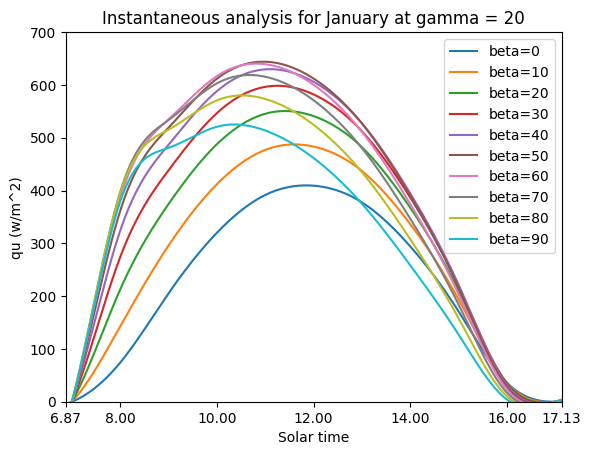

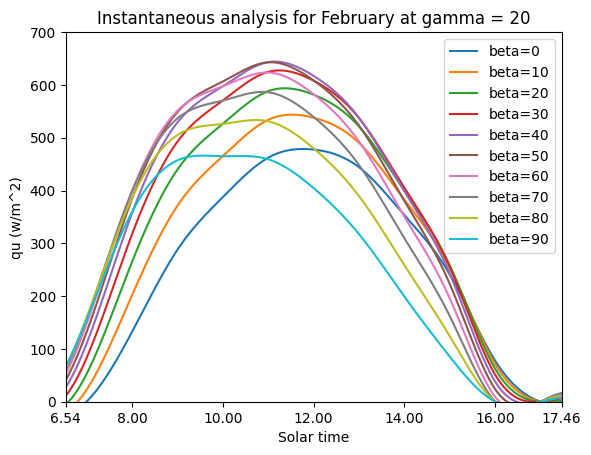

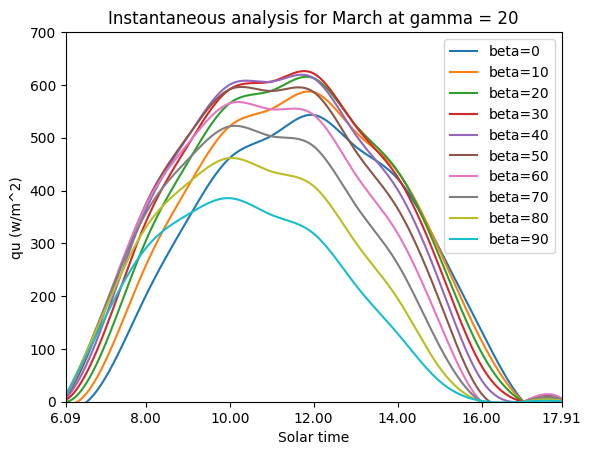

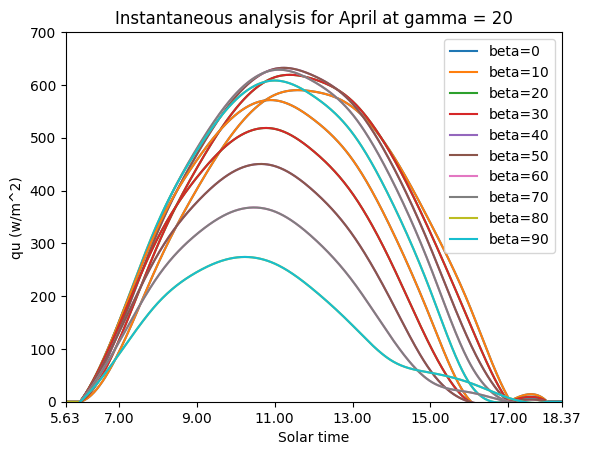

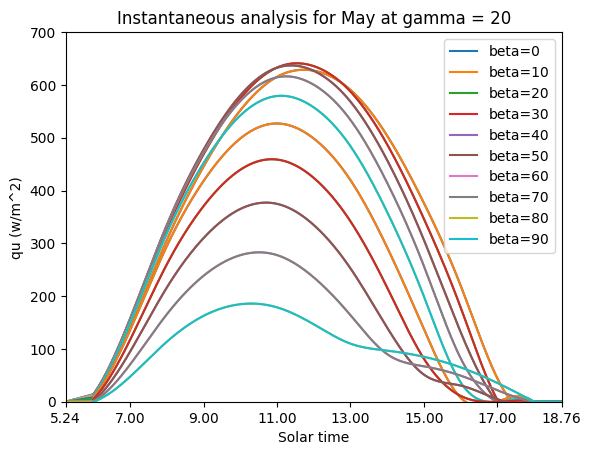

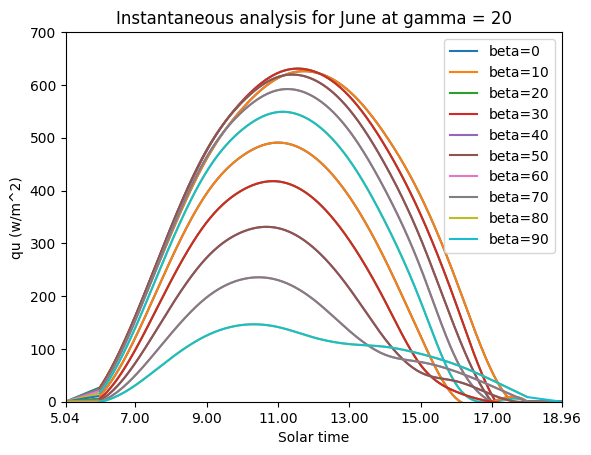

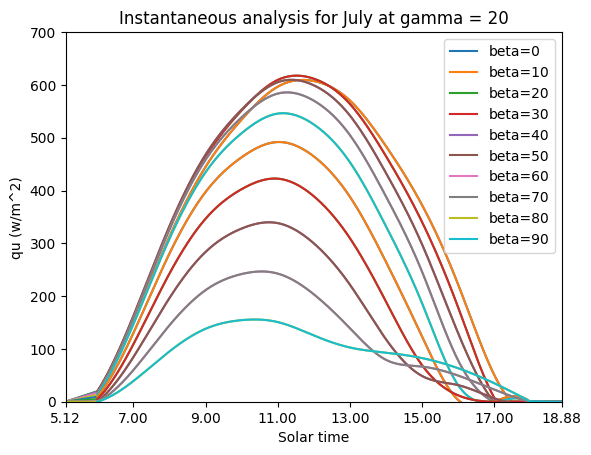

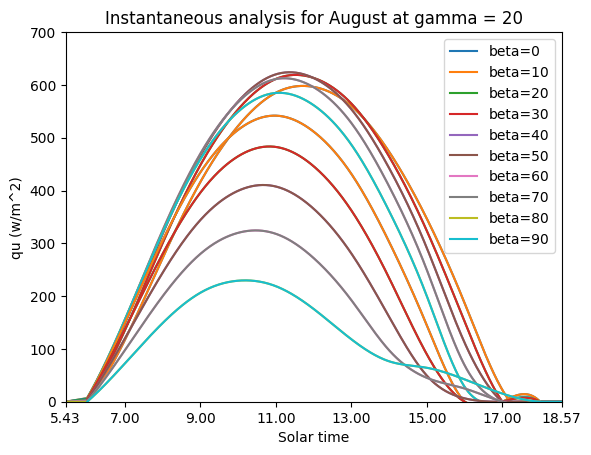

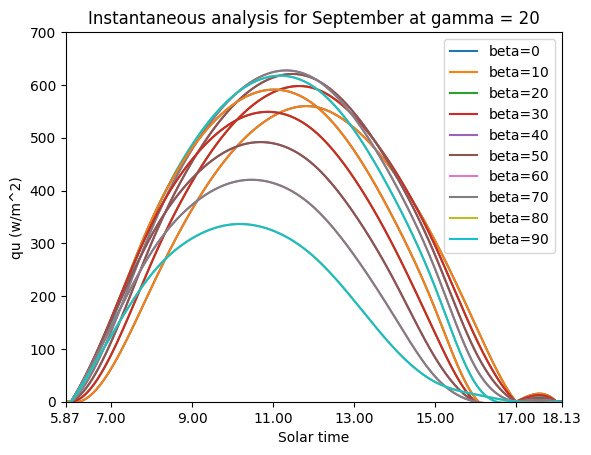

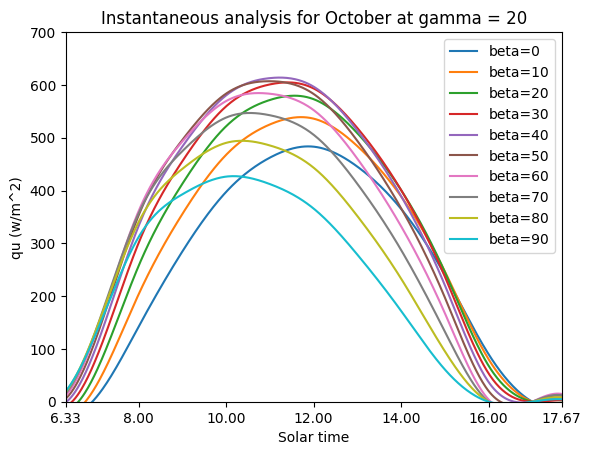

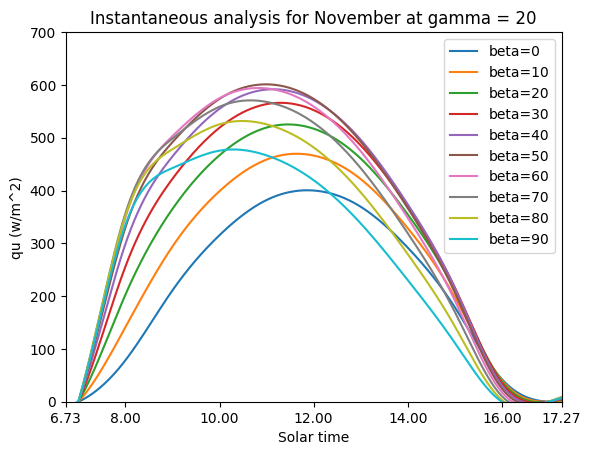

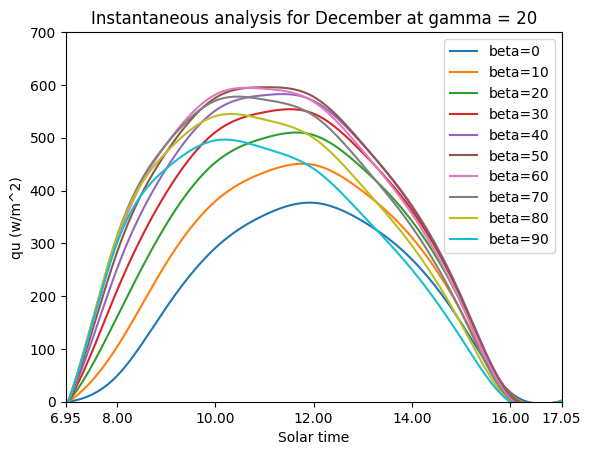

<Figure size 640x480 with 0 Axes>

In [60]:
for x in range(12):
    mon = x+1
    for i in range(10):
        if srs[mon-1]<6 or sss[mon-1]>18:
            if srs[mon-1]<6:
                start = list([srs[mon-1]]+list(interpolate(st,Q_y[mon-1][i])[0]))
                end = list([0]+list(interpolate(st,Q_y[mon-1][i])[1]))
                plt.plot(start,end)
            if sss[mon-1]>18:
                plt.plot(list(interpolate(st,Q_y[mon-1][i])[0])+[sss[mon-1]],list(interpolate(st,Q_y[mon-1][i])[1])+[0])
        else:
            plt.plot(interpolate(st,Q_y[mon-1][i])[0],interpolate(st,Q_y[mon-1][i])[1])
    plt.legend(["beta=0",
                "beta=10",
                "beta=20",
                "beta=30",
                "beta=40",
                "beta=50",
                "beta=60",
                "beta=70",
                "beta=80",
                "beta=90"])
    plt.title(f"Instantaneous analysis for {months[mon-1]} at gamma = {gamma}")
    plt.xlabel("Solar time")
    srs_m = srs[mon-1]
    sss_m = sss[mon-1]
    plt.xlim([srs_m,sss_m])
    plt.ylim([0,700])

    plt.xticks([srs_m]+list(np.arange(math.ceil(srs[mon-1])+1 , 18,2))+[sss_m])
    plt.ylabel("qu (w/m^2)")
    
    plt.show()
    plt.clf()

# Daily analysis

In [61]:
Q_yd = []
for mo in range(12):
    m = mo+1
    n = avg_d[m-1]
    Q_m = []
    for ga in range(10):
        gamma = ga*10
        I_total_g = []
        S_g = []
        Q_g = []
        for be in range(10):
            beta = 10*be
            theta_in = []
            theta_z_in = []
            rb_in = []
            I_total_in = []
            thetadash_in = []
            roh1_in = []
            roh2_in = []
            tau1_in = []
            tau2_in = []
            tau_r = []
            tau_a_in = []
            tau = []
            alpha_in = []
            tau_a_b_in = []
            S_in = []
            qu = []

            # DIFFUSE
            rd_in = rd(beta)
            rr_in = rr(beta, roh_g)
            tau_a_d_in = tau_alp_d(thta_diff, ng, na, n_o_c, k, delC, roh_d)

            # TANK
            L = (W-Do)/2
            F = fin_eff(U,K,cpst,L)
            F_d = collector_eff(U,W,L,F,Do,cb,Di,hci)
            FR = hear_removal_factor(mw,cw,U,F_d)
            for i in range(len(st)):
                theta_in.append(theta(beta,decl(n),gamma,ha(st[i]),phi))
                theta_z_in.append(theta_z(decl(n),gamma,ha(st[i]),phi))
                if rb(n,st[i],beta ,gamma, phi) < 0:
                    rb_in.append(0)
                else:
                    rb_in.append(rb(n,st[i],beta ,gamma, phi))
                I_total_in.append(I_total(I[m-1][0][i],I[m-1][1][i],rb_in[i],rd(beta),rr(beta,0.2)))
                thetadash_in.append(thetadash(ng,na,theta_in[i]))
                roh1_in.append(roh1(theta_in[i],thetadash_in[i]))
                roh2_in.append(roh2(theta_in[i],thetadash_in[i]))
                tau1_in.append(tau1(roh1_in[i],n_o_c))
                tau2_in.append(tau1(roh2_in[i],n_o_c))
                tau_r.append((tau1_in[i]+tau2_in[i])*0.5)
                tau_a_in.append(tau_a(thetadash_in[i],k,delC))
                tau.append(tau_a_in[i]*tau_r[i])  
                alpha_in.append(alpha(theta_in[i]))
                tau_a_b_in.append(tau_alp_b(tau[i],alpha_in[i],roh_d))
                S_in.append(S(I[m-1][0][i],I[m-1][1][i],rb_in[i], rd_in, rr_in, tau_a_b_in[i], tau_a_d_in))
            ta = Ta_r[m-1][1] - DR[0]*(Ta_r[m-1][1]-Ta_r[m-1][0])/100
            tw_n = [Twi[m-1]]
            if FR*(S_in[0]-U*(Twi[m-1]-ta)) < 0 :
                qu.append(0)
            else:
                qu.append(FR*(S_in[0]-U*(Twi[m-1]-ta)))

            for i in range(1,len(st)): 
                two = tw_n[i-1]+(qu[i-1]/(mw*cw))
                tw_n.append((two+tw_n[i-1])/2)
                ta = Ta_r[m-1][1] - DR[i]*(Ta_r[m-1][1]-Ta_r[m-1][0])/100
                if FR*(S_in[i]-U*(tw_n[i]-ta)) > 0: 
                    qu.append(FR*(S_in[i]-U*(tw_n[i]-ta)))
                else:
                    qu.append(0)
            Q_daily = sum(qu[1:len(qu)])*(3600/pow(10,6))
            Q_g.append(Q_daily)   
        Q_m.append(Q_g)      
    Q_yd.append(Q_m)    

### Plots

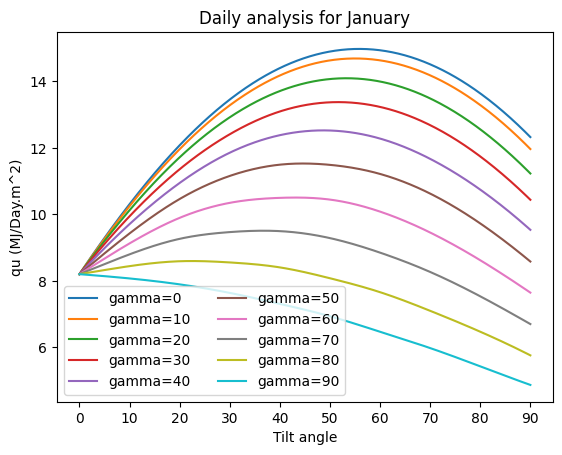

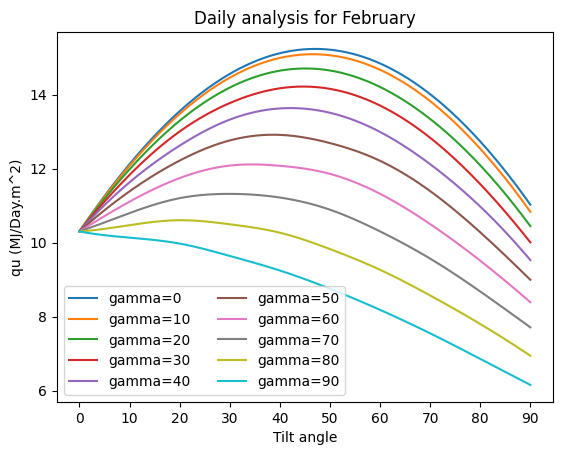

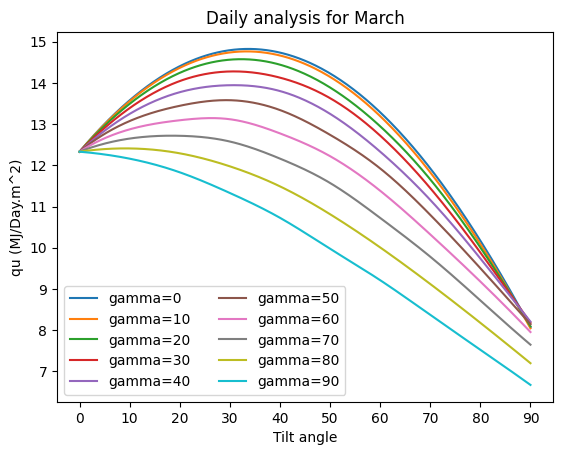

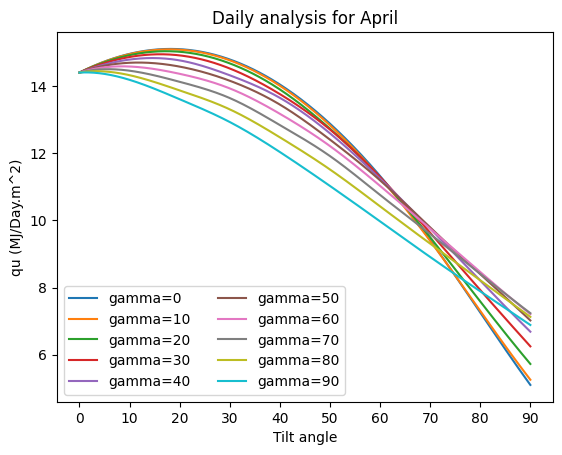

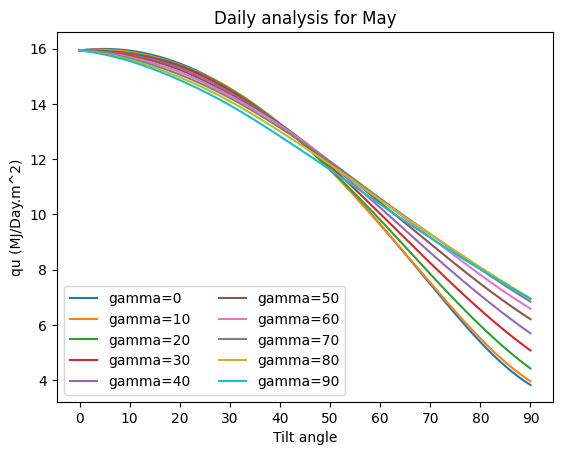

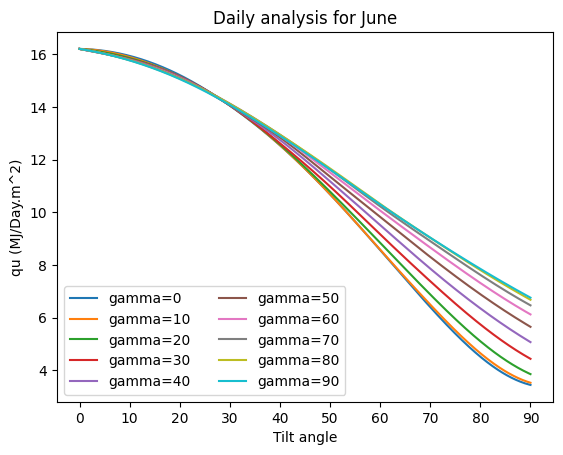

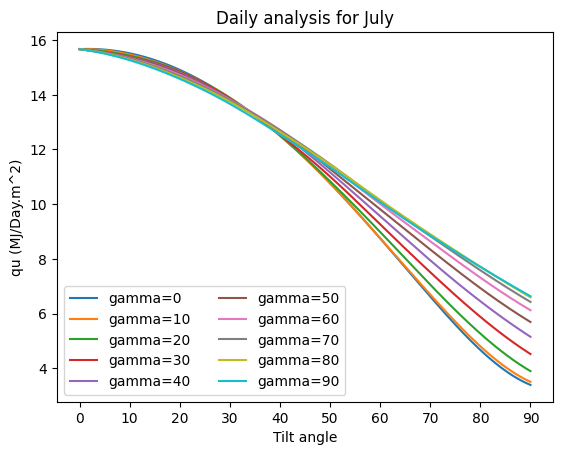

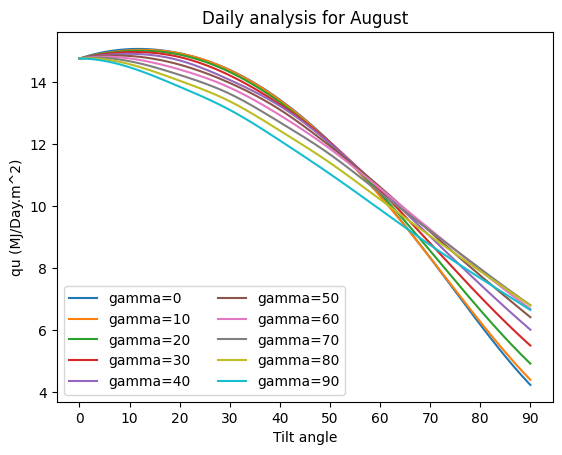

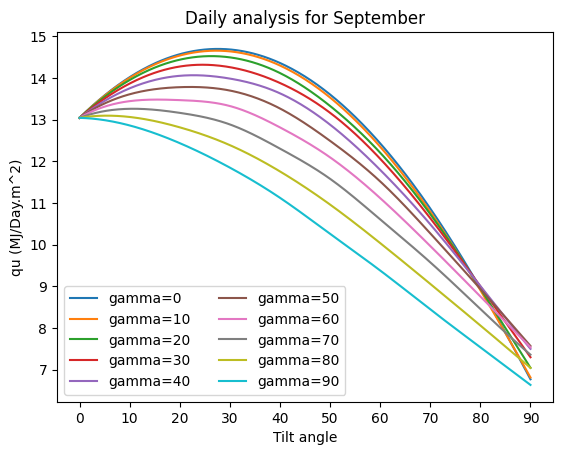

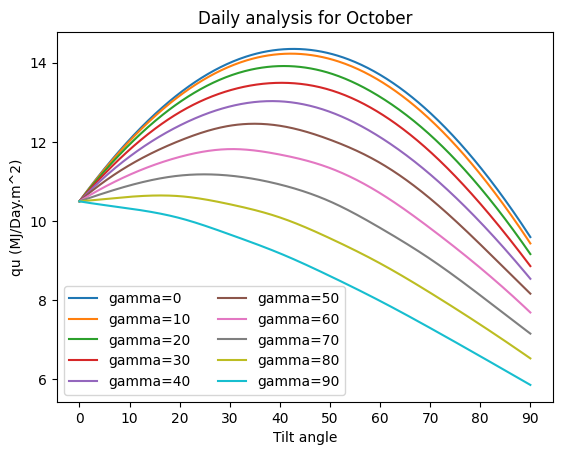

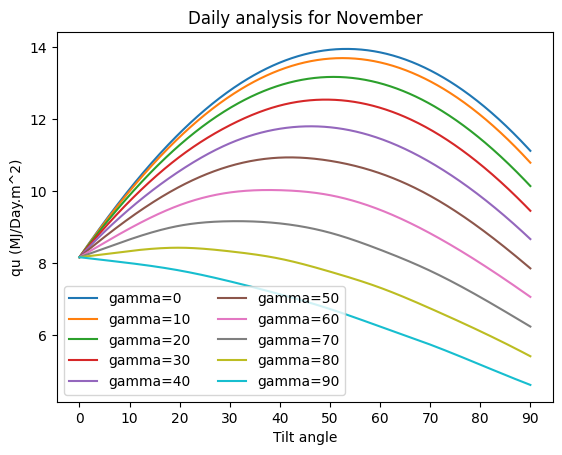

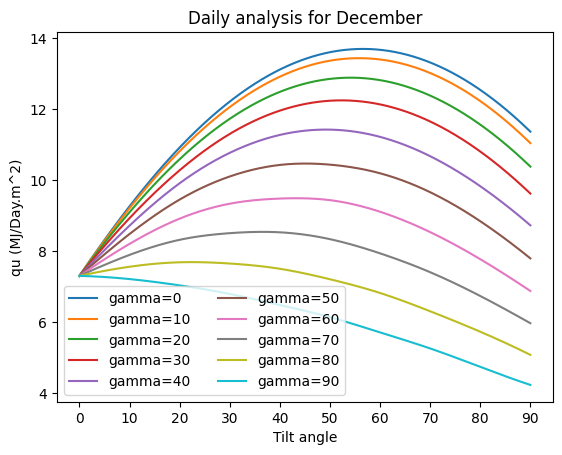

<Figure size 640x480 with 0 Axes>

In [62]:
for x in range(12):
    mon = x+1
    for i in range(10):  
        plt.plot(
            interpolate(list(range(0,100,10)),Q_yd[mon-1][i])[0],interpolate(list(range(0,100,10)),Q_yd[mon-1][i])[1]
        )
    plt.xticks(range(0,100,10))
    plt.legend(["gamma=0",
                "gamma=10",
                "gamma=20",
                "gamma=30",
                "gamma=40",
                "gamma=50",
                "gamma=60",
                "gamma=70",
                "gamma=80",
                "gamma=90"] , ncol=2)
    plt.title(f"Daily analysis for {months[mon-1]}")
    plt.xlabel("Tilt angle")
    plt.ylabel("qu (MJ/Day.m^2)")
    plt.show()
    plt.clf()

### Find the optimum Beta and Gamma for maximum Q daily

In [63]:
opt_betas = []
opt_gammas = []
max_q = []
for i in range(12):
    mx = list(map(max,Q_yd[i]))
    gmx = max(mx)
    gam_ind = mx.index(gmx)
    gam_opt = gam_ind*10
    be_opt = Q_yd[i][gam_ind].index(gmx)*10
    opt_betas.append(be_opt)
    opt_gammas.append(gam_opt)    
    max_q.append(gmx)

In [64]:
Optimum_data = pd.DataFrame(data= {
    "Month":months,
    "Optimum Tilt angle": opt_betas,
    "Optimum Gamma": opt_gammas,
    "Maximum rate of useful energy gain per day" : max_q 
})
Optimum_data.style.set_table_attributes("style = 'font-size:11px; font-weight:700; text-align:center'").set_caption("Optimum Beta and Gamma for maximum Q daily")

,Month,Optimum Tilt angle,Optimum Gamma,Maximum rate of useful energy gain per day
0,January,60,0,14.939778
1,February,50,0,15.214562
2,March,30,0,14.791229
3,April,20,0,15.094551
4,May,0,0,15.936337
5,June,0,0,16.202837
6,July,0,0,15.670842
7,August,10,0,15.057775
8,September,30,0,14.682694
9,October,40,0,14.331664


# Yearly analysis

In [65]:
Q_y = []
d_i_m = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] 
for i in range(10):
    Q_yb = []
    for b in range(10):
        sums = 0
        for m in range(12):
            sums += Q_yd[m][i][b]*d_i_m[m]
        Q_yb.append(sums)
    Q_y.append(Q_yb)

## Plot

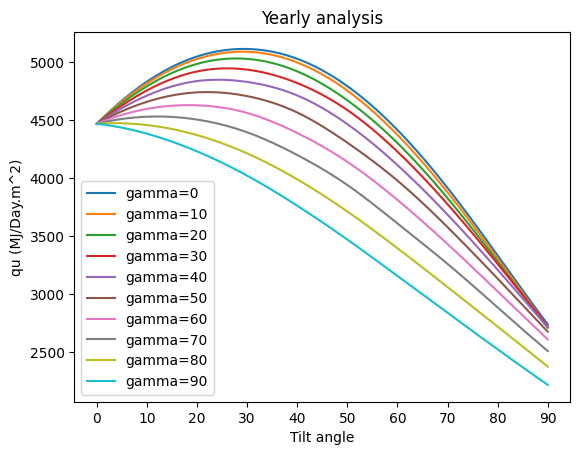

In [66]:
for i in range(10):  
    plt.plot(
        interpolate(list(range(0,100,10)),Q_y[i])[0],interpolate(list(range(0,100,10)),Q_y[i])[1]
    )
plt.xticks(range(0,100,10))
plt.legend(["gamma=0",
            "gamma=10",
            "gamma=20",
            "gamma=30",
            "gamma=40",
            "gamma=50",
            "gamma=60",
            "gamma=70",
            "gamma=80",
            "gamma=90"])
plt.title(f"Yearly analysis")
plt.xlabel("Tilt angle")
plt.ylabel("qu (MJ/Day.m^2)")
plt.show()

### Find the optimum Beta and Gamma for maximum Q yearly

In [67]:
mx = list(map(max,Q_y))
gmx = max(mx)
gam_ind = mx.index(gmx)
gam_opt_y = gam_ind*10
be_opt_y = Q_y[gam_ind].index(gmx)*10   

In [68]:
Optimum_data_y = pd.DataFrame(data= {
    "Optimum Tilt angle": [be_opt_y],
    "Optimum Gamma":[gam_opt_y],
    "Maximum rate of useful energy gain per year" : [gmx]
})
Optimum_data_y.style.set_table_attributes("style = 'font-size:14px; font-weight:700; text-align:center'").set_caption("Optimum Beta and Gamma for maximum Q yearly")


,Optimum Tilt angle,Optimum Gamma,Maximum rate of useful energy gain per year
0,30,0,5113.227884


In [69]:
gamma = 20
beta = 30
phi = 30
n_o_c = 1
k = 0.0068
ng = 1.526
na = 1
delC = 4
roh_g = 0.2
U = 5
K = 385
cpst = 0.5/1000
Do= 11/1000
Di= 10/1000
cb = 35
W = 150/1000
mw = 0.015
cw = 4180
hci = 300
twh=55
vw = 250
Twh=55
thta_diff = 20
if n_o_c == 1 :
    roh_d = 0.15
elif n_o_c == 2:
    roh_d = 0.22
elif n_o_c == 3: 
    roh_d = 0.24

In [70]:
Q_Months = []
for i in range(12):
    m = i+1
    n = avg_d[m-1]
    theta_in = []
    theta_z_in = []
    rb_in = []
    I_total_ins = []
    thetadash_in = []
    roh1_in = []
    roh2_in = []
    tau1_in = []
    tau2_in = []
    tau_r = []
    tau_a_in = []
    tau = []
    alpha_in = []
    tau_a_b_in = []
    S_in = []
    qu = []

    # DIFFUSE
    rd_in = rd(beta)
    rr_in = rr(beta, roh_g)
    tau_a_d_in = tau_alp_d(thta_diff, ng, na, n_o_c, k, delC, roh_d)

    # TANK
    L = (W-Do)/2
    F = fin_eff(U,K,cpst,L)
    F_d = collector_eff(U,W,L,F,Do,cb,Di,hci)
    FR = hear_removal_factor(mw,cw,U,F_d)
    for i in range(len(st)):
        theta_in.append(theta(beta,decl(n),gamma,ha(st[i]),phi))
        theta_z_in.append(theta_z(decl(n),gamma,ha(st[i]),phi))
        if rb(n,st[i],beta ,gamma, phi) < 0:
            rb_in.append(0)
        else:
            rb_in.append(rb(n,st[i],beta ,gamma, phi))
        I_total_in.append(I_total(I[m-1][0][i],I[m-1][1][i],rb_in[i],rd(beta),rr(beta,0.2)))
        thetadash_in.append(thetadash(ng,na,theta_in[i]))
        roh1_in.append(roh1(theta_in[i],thetadash_in[i]))
        roh2_in.append(roh2(theta_in[i],thetadash_in[i]))
        tau1_in.append(tau1(roh1_in[i],n_o_c))
        tau2_in.append(tau1(roh2_in[i],n_o_c))
        tau_r.append((tau1_in[i]+tau2_in[i])*0.5)
        tau_a_in.append(tau_a(thetadash_in[i],k,delC))
        tau.append(tau_a_in[i]*tau_r[i])  
        alpha_in.append(alpha(theta_in[i]))
        tau_a_b_in.append(tau_alp_b(tau[i],alpha_in[i],roh_d))
        S_in.append(S(I[m-1][0][i],I[m-1][1][i],rb_in[i], rd_in, rr_in, tau_a_b_in[i], tau_a_d_in))
    ta = Ta_r[m-1][1] - DR[0]*(Ta_r[m-1][1]-Ta_r[m-1][0])/100
    tw_n = [Twi[m-1]]
    if FR*(S_in[0]-U*(Twi[m-1]-ta)) < 0 :
        qu.append(0)
    else:
        qu.append(FR*(S_in[0]-U*(Twi[m-1]-ta)))

    for i in range(1,len(st)): 
        two = tw_n[i-1]+(qu[i-1]/(mw*cw))
        tw_n.append((two+tw_n[i-1])/2)
        ta = Ta_r[m-1][1] - DR[i]*(Ta_r[m-1][1]-Ta_r[m-1][0])/100
        if FR*(S_in[i]-U*(tw_n[i]-ta)) > 0: 
            qu.append(FR*(S_in[i]-U*(tw_n[i]-ta)))
        else:
            qu.append(0)
    I_total_daily = sum(I_total_ins[1:len(I_total_ins)])*(3600/pow(10,6))
    S_daily = sum(S_in[1:len(S_in)])*(3600/pow(10,6))
    Q_daily = sum(qu[1:len(qu)])*(3600/pow(10,6))
    Q_Months.append(Q_daily)

In [71]:
days_in = [31, 28,31,30,31,30,31,31,30,31,30,31]

In [72]:
monthly_de = []
monthly_s = []
monthly_diff = []
for i in range(12):
    m = i + 1
    demand = vw*cw*(Twh-Twi[i])*days_in[i]/1000000
    monthly_s.append(Q_Months[i]*days_in[i]*3)
    monthly_de.append(demand)
    monthly_diff.append(Q_Months[i]*days_in[i]*3-demand)

In [73]:
months_ds = pd.DataFrame(data={
    "Month" : months,
    "Energy Demand(watt)" : monthly_de,
    "Energy Supply(watt)" : monthly_s,
    "Difference" : monthly_diff
})
months_ds

,Month,Energy Demand(watt),Energy Supply(watt),Difference
0,January,1302.2790,1201.818231,-100.460769
1,February,1138.2140,1192.007998,53.793998
2,March,1153.2620,1354.192770,200.930770
3,April,1012.6050,1320.463881,307.858881
4,May,994.5265,1351.411097,356.884597
5,June,862.1250,1265.783479,403.658479
6,July,858.4675,1291.237169,432.769669
7,August,832.5515,1331.798563,499.247063
8,September,849.5850,1304.345280,454.760280
9,October,939.4550,1271.171324,331.716324


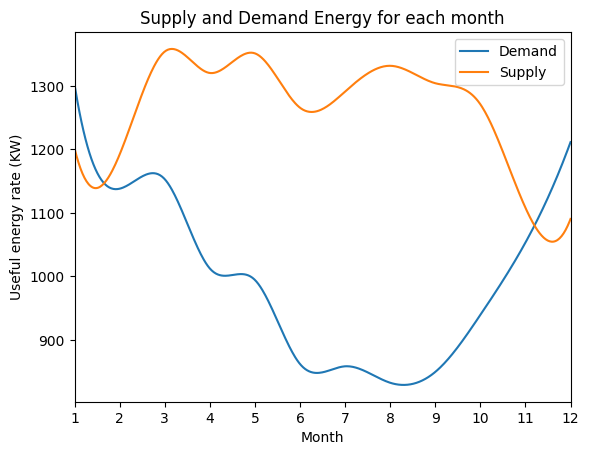

In [74]:
plt.plot(
    interpolate(np.arange(1,13,1), monthly_de)[0],interpolate(np.arange(1,13,1), monthly_de)[1]
)
plt.plot(
    interpolate(np.arange(1,13,1), monthly_s)[0],interpolate(np.arange(1,13,1), monthly_s)[1]
)
plt.xlim([1,12])
plt.xticks(np.arange(1,13,1))
plt.title("Supply and Demand Energy for each month")
plt.xlabel("Month")
plt.ylabel("Useful energy rate (KW)")
plt.legend(["Demand","Supply"])
plt.savefig("Supply and Demand.png")
plt.show()


In [75]:
cond1 = ((interpolate(np.arange(1,13,1), monthly_s)[1]<interpolate(np.arange(1,13,1), monthly_de)[1]) * (interpolate(np.arange(1,13,1), monthly_s)[0]<2))
cond2 = ((interpolate(np.arange(1,13,1), monthly_s)[1]<interpolate(np.arange(1,13,1), monthly_de)[1]) * (interpolate(np.arange(1,13,1), monthly_s)[0]>11))
sup1 = simpson(interpolate(np.arange(1,13,1), monthly_s)[1][cond1], x=interpolate(np.arange(1,13,1), monthly_s)[0][cond1])
dem1 = simpson(interpolate(np.arange(1,13,1), monthly_de)[1][cond1], x=interpolate(np.arange(1,13,1), monthly_de)[0][cond1])
sup2 = simpson(interpolate(np.arange(1,13,1), monthly_s)[1][cond2], x=interpolate(np.arange(1,13,1), monthly_s)[0][cond2])
dem2 = simpson(interpolate(np.arange(1,13,1), monthly_de)[1][cond2], x=interpolate(np.arange(1,13,1), monthly_de)[0][cond2])
shortage = sup1+sup2-dem1-dem2
print("Shortage =", -shortage , "Watt")

Shortage = 94.9688414887031 Watt
